## Experiment
- htd on resnet

In [1]:
import sys 

EXP_DIR = "/home/fmokadem/NAS/tdcnn/"
sys.path.append(EXP_DIR)

In [2]:
import os
import sys
import torch
from torchvision import models
import time
import random
import numpy as np
import itertools
import math
import argparse
from datetime import datetime
import json
import copy


In [3]:
from common.dataset import load_mnist
from common._logging import setup_logger
from common.utils import (
    count_parameters, 
    measure_inference_time, 
    calculate_accuracy, 
    get_flops, 
    get_conv2d_layers,
    infer_rank, 
    calculate_layer_params,
    replace_conv2d_with_tucker,
    fine_tune
)
from common.load_models import load_model

In [4]:
MODEL_NAME = 'vgg'
FINETUNE = True
MAX_CFG = 250
ACCU_RQT = .90

In [5]:
MODEL_PATH = os.path.join(EXP_DIR, f'finetuned/saved_models/{MODEL_NAME}16_mnist.pth')
LOG_DIR = os.path.join(EXP_DIR, 'logs')
LOG_PREFIX = 'htd_vgg16'

In [6]:
logger = setup_logger(LOG_PREFIX, LOG_DIR, LOG_PREFIX)
logger.info(f"Starting HTD experiment for {MODEL_NAME}")
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

2025-03-30 08:21:14,427 - MainProcess - INFO - Logging to /home/fmokadem/NAS/tdcnn/logs/htd_vgg16_20250330_082114.log
2025-03-30 08:21:14,428 - MainProcess - INFO - Starting HTD experiment for vgg


In [7]:
# use gpu 0 only
device_idx = 0

if torch.cuda.is_available():
    torch.cuda.set_device(device_idx)
    device = f'cuda:{device_idx}'
else:
    device = "cpu"

logger.info(f"Using device: {device}")

2025-03-30 08:21:14,541 - MainProcess - INFO - Using device: cuda:0


In [8]:
# Load dataset
train_loader, test_loader = load_mnist()
logger.info(f"MNIST loaded: {len(train_loader.dataset)} train, {len(test_loader.dataset)} test samples")

# Load model
model = load_model(MODEL_NAME, MODEL_PATH, device)
logger.info(f"Loaded {MODEL_NAME} from {MODEL_PATH}")

2025-03-30 08:21:14,647 - MainProcess - INFO - MNIST loaded: 60000 train, 10000 test samples
/home/fmokadem/NAS/tdcnn/common/load_models.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experim

In [9]:
train_loader.dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=3)
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [10]:
from torchsummary import summary
summary(model, (3, 244, 244))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 244, 244]           1,792
              ReLU-2         [-1, 64, 244, 244]               0
            Conv2d-3         [-1, 64, 244, 244]          36,928
              ReLU-4         [-1, 64, 244, 244]               0
         MaxPool2d-5         [-1, 64, 122, 122]               0
            Conv2d-6        [-1, 128, 122, 122]          73,856
              ReLU-7        [-1, 128, 122, 122]               0
            Conv2d-8        [-1, 128, 122, 122]         147,584
              ReLU-9        [-1, 128, 122, 122]               0
        MaxPool2d-10          [-1, 128, 61, 61]               0
           Conv2d-11          [-1, 256, 61, 61]         295,168
             ReLU-12          [-1, 256, 61, 61]               0
           Conv2d-13          [-1, 256, 61, 61]         590,080
             ReLU-14          [-1, 256,

In [11]:
# Extract Conv2D layers
conv_layers = get_conv2d_layers(model)
logger.info(f"Found {len(conv_layers)} Conv2D layers in {MODEL_NAME}")
conv_layers

2025-03-30 08:21:16,984 - MainProcess - INFO - Found 13 Conv2D layers in vgg


{'features.0': Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 'features.2': Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 'features.5': Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 'features.7': Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 'features.10': Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 'features.12': Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 'features.14': Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 'features.17': Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 'features.19': Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 'features.21': Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 'features.24': Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 'features.26': Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding

In [12]:
# Initialize layer information
# Conv2 layers in Pytorch are (Cin, Cout, ks, ks), i.e. a 4D tensor with rank 4, called modes 0 to 3
# we are interested in low rank approximating of modes 0 and 1, i.e. compressing the information in  the channels
# each mode is almost always full rank, i.e. of rank == size
# therefore for the pupose of this exp rank of a layer is the min(Cin, Cout) 


# TODO: complexity ranks in decreasing order layers that are closest to the middle.  
layer_info = {}
for name, layer in conv_layers.items():
    r_i = infer_rank(layer)
    layer_info[name] = {
        'layer': layer,
        'r_i': r_i,
        'params': calculate_layer_params(layer),
        'complexity': None
    }
    logger.info(f"Layer {name}: initial rank R_i = {r_i}, parameters = {layer_info[name]['params']}")

2025-03-30 08:21:17,000 - MainProcess - INFO - Layer features.0: initial rank R_i = 3, parameters = 1728
2025-03-30 08:21:17,001 - MainProcess - INFO - Layer features.2: initial rank R_i = 64, parameters = 36864
2025-03-30 08:21:17,002 - MainProcess - INFO - Layer features.5: initial rank R_i = 64, parameters = 73728
2025-03-30 08:21:17,002 - MainProcess - INFO - Layer features.7: initial rank R_i = 128, parameters = 147456
2025-03-30 08:21:17,003 - MainProcess - INFO - Layer features.10: initial rank R_i = 128, parameters = 294912
2025-03-30 08:21:17,004 - MainProcess - INFO - Layer features.12: initial rank R_i = 256, parameters = 589824
2025-03-30 08:21:17,004 - MainProcess - INFO - Layer features.14: initial rank R_i = 256, parameters = 589824
2025-03-30 08:21:17,005 - MainProcess - INFO - Layer features.17: initial rank R_i = 256, parameters = 1179648
2025-03-30 08:21:17,006 - MainProcess - INFO - Layer features.19: initial rank R_i = 512, parameters = 2359296
2025-03-30 08:21:17,

In [13]:
layer_info

{'features.0': {'layer': Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
  'r_i': 3,
  'params': 1728,
  'complexity': None},
 'features.2': {'layer': Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
  'r_i': 64,
  'params': 36864,
  'complexity': None},
 'features.5': {'layer': Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
  'r_i': 64,
  'params': 73728,
  'complexity': None},
 'features.7': {'layer': Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
  'r_i': 128,
  'params': 147456,
  'complexity': None},
 'features.10': {'layer': Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
  'r_i': 128,
  'params': 294912,
  'complexity': None},
 'features.12': {'layer': Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
  'r_i': 256,
  'params': 589824,
  'complexity': None},
 'features.14': {'layer': Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
  'r_i': 25

In [14]:
# Compute baseline metrics
baseline_params = count_parameters(model)
baseline_flops = get_flops(model)
baseline_accuracy = calculate_accuracy(model, test_loader, device)
baseline_inference_time = measure_inference_time(model, test_loader, device, num_runs=3)

logger.info(f"Baseline {MODEL_NAME}: params={baseline_params}, "
            f"FLOPs={baseline_flops}, accuracy={baseline_accuracy:.4f}, "
            f"inference_time={baseline_inference_time:.4f}s")

# Timestamp for unique file naming
timestamp = time.strftime("%Y%m%d_%H%M%S")

2025-03-30 08:22:52,744 - MainProcess - INFO - Baseline vgg: params=134301514, FLOPs=15519169546, accuracy=0.9956, inference_time=0.1387s


In [15]:
# Generate possible ranks per layer, that is 1 up to it's rank - 1 
# if layer is of rank 1, then possible ranks are just 1
possible_ranks = {}
for name, info in layer_info.items():
    r_i = info['r_i']
    ranks = [1] + list(range(2, r_i)) 
    possible_ranks[name] = ranks

total_possible_configs = abs(np.prod([max(1, layer_info[name]['r_i'] - 1) for name in layer_info.keys()]))
num_configs_to_try = min(total_possible_configs, MAX_CFG)
logger.info(f"Total possible configurations: {total_possible_configs}, will try: {num_configs_to_try}")

2025-03-30 08:22:52,749 - MainProcess - INFO - Total possible configurations: 6059305734288801022, will try: 250


In [16]:
from torch import nn
def construct_layer_dict(model):
    layer_dict = {}
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            W = module.weight.data
            cin = module.in_channels
            cout = module.out_channels
            layer_dict[name] = (W, cin, cout)
    return layer_dict

layer_dict = construct_layer_dict(model)

In [17]:
from tensorly.decomposition import partial_tucker
import tensorly as tl    
from tensorly.tucker_tensor import tucker_to_tensor
from tensorly.metrics.regression import MSE

tl.set_backend('pytorch')

# # Heuristic: layers with bigger cin*cout more suseptible to lower ranks 
# def get_size_probs(cin, cout, rank_candidates, beta=1.0):
#     size = cin * cout
#     preference = np.log(size + 1)  # +1 to avoid log(0), though unlikely
#     scores = [-beta * r / preference for r in rank_candidates]
#     probs = np.exp(scores) / np.sum(np.exp(scores))
#     return probs

# # Heuristic: Layers with higher reconstruction erros are less suseptible to low ranks 
# def compute_sensitivity(W, cin, cout):
#     rank = [max(1, cout // 2), max(1, cin // 2)]
#     (core, factors) = partial_tucker(W, modes=[0, 1], rank=rank, init='svd')
       
#     reconstructed_W = tucker_to_tensor(core, factors)
#     return MSE(W, reconstructed_W) 

# # Precompute sensitivity for all layers
# def precompute_sensitivities(layer_dict):
#     sensitivities = {}
#     for name, (W, cin, cout) in layer_dict.items():
#         sensitivities[name] = compute_sensitivity(W, cin, cout).to('cpu')
#     # Normalize sensitivities to [0, 1]
#     max_error = max(list(sensitivities.values()))
#     if max_error > 0:  # Avoid division by zero
#         sensitivities = {name: err / max_error for name, err in sensitivities.items()}
#     return sensitivities
    
# def get_sensitivity_probs(sensitivity, rank_candidates, alpha=1.0):
#     max_rank = max(rank_candidates)
#     scores = [(r / max_rank) ** (alpha * sensitivity) for r in rank_candidates]
#     probs = scores / np.sum(scores)
#     return probs

# def get_rank_candidates(channels, r=(75, 49, -25)):
#     s, f, stride = r
#     percentages = np.arange(s, f, stride) / 100
#     candidates = set([max(1, int(channels * p)) for p in percentages])
#     return candidates
# def softmax(x: np.ndarray) -> np.ndarray:
#     x_max = np.max(x)  # Avoid overflow
#     exp_x = np.exp(x - x_max)  # Shift values
#     return exp_x / np.sum(exp_x)

In [18]:
import numpy as np
import random
from scipy.special import softmax

def get_rank_candidates(channels, r=(90, 24, -5)):
    s, f, stride = r
    percentages = np.arange(s, f, stride) / 100
    candidates = set([max(1, int(channels * p)) for p in percentages])
    return candidates

def compute_sensitivity(W, cin, cout):
    rank = [max(1, cout // 2), max(1, cin // 2)]
    (core, factors) = partial_tucker(W, modes=[0, 1], rank=rank, init='svd')
    reconstructed_W = tucker_to_tensor(core, factors)
    return MSE(W, reconstructed_W)

def precompute_sensitivities(layer_dict):
    sensitivities = {}
    for name, (W, cin, cout) in layer_dict.items():
        sensitivities[name] = compute_sensitivity(W, cin, cout).to('cpu').item()
    max_error = max(sensitivities.values())
    if max_error > 0:
        sensitivities = {name: err / max_error for name, err in sensitivities.items()}
    return sensitivities

def get_sensitivity_scores(sensitivity, rank_candidates, alpha=1.0):
    max_rank = max(rank_candidates)
    return [(r / max_rank) ** (alpha * sensitivity) for r in rank_candidates]

def get_size_based_scores(cin, cout, rank_candidates, beta=1.0):
    size = cin * cout
    preference = np.log(size + 1)
    return [-beta * r / preference for r in rank_candidates]

In [19]:
def generate_configs(layer_dict, sensitivities, num_cfg=500, alpha=1.0, beta=1.0):
    for _ in range(num_cfg):
        config = {}
        for name, (W, cin, cout) in layer_dict.items():
            cin_candidates = list(get_rank_candidates(cin))
            cout_candidates = list(get_rank_candidates(cout))
            sensitivity = sensitivities[name]

            # Combine scores for cin
            cin_sen_scores = get_sensitivity_scores(sensitivity, cin_candidates, alpha)
            cin_size_scores = get_size_based_scores(cin, cout, cin_candidates, beta)
            cin_probs = softmax(np.array(cin_sen_scores) + np.array(cin_size_scores))

            # Combine scores for cout
            cout_sen_scores = get_sensitivity_scores(sensitivity, cout_candidates, alpha)
            cout_size_scores = get_size_based_scores(cin, cout, cout_candidates, beta)
            cout_probs = softmax(np.array(cout_sen_scores) + np.array(cout_size_scores))

            # Sample ranks
            cin_rank = random.choices(cin_candidates, weights=cin_probs)[0]
            cout_rank = random.choices(cout_candidates, weights=cout_probs)[0]
            config[name] = (cin_rank, cout_rank)
        yield config

In [20]:
# # Generator function to yield num_cfg configurations
# def generate_configs(layer_dict, num_cfg):
    
    
#     # Precompute rank candidates for each layer
#     rank_candidates = {}
#     for name, (W, cin, cout) in layer_dict.items():
#         cin_candidates = get_rank_candidates(cin)  
#         cout_candidates = get_rank_candidates(cout)  
        
#         rank_pairs = list(itertools.product(cin_candidates, cout_candidates))
#         rank_candidates[name] = rank_pairs
#         # we sort to keep higher ranks on top of the search 
#         # no heuristic, budget num_cfg accross all layers equally 
#         # num_cfg / len(layer_dict.keys) searches per layer
#         # spl = int(num_cfg ** (1 / len(layer_dict.keys())))
#         # rank_candidates[name] = sorted(rank_pairs, key=lambda x: (-x[0], -x[1]))[:spl]
    
#     # Yield exactly num_cfg random configurations
#     for config in itertools.product(*rank_candidates.values()):
#         yield dict(zip(layer_dict.keys(), config))

In [21]:
sensitivities = precompute_sensitivities(layer_dict)
configs = generate_configs(layer_dict, sensitivities, num_cfg=500, alpha=1.0, beta=1.0)
next(configs)

{'features.0': (1, 16),
 'features.2': (19, 19),
 'features.5': (25, 32),
 'features.7': (38, 38),
 'features.10': (32, 64),
 'features.12': (140, 76),
 'features.14': (64, 64),
 'features.17': (76, 128),
 'features.19': (179, 128),
 'features.21': (128, 128),
 'features.24': (128, 128),
 'features.26': (128, 128),
 'features.28': (128, 128)}

In [22]:
import matplotlib.pyplot as plt
import numpy as np
configs = [config for config in generate_configs(layer_dict, sensitivities, num_cfg=500, alpha=1.0, beta=1.0)]

def plot_compression_dist_boxplot(layer_dict, configs):
    # Step 1: Calculate average rin and rout per layer across configs
    avg_ranks = {name: {'rin': [], 'rout': []} for name in layer_dict.keys()}
    for config in configs:
        for name, (rin, rout) in config.items():
            avg_ranks[name]['rin'].append(rin)
            avg_ranks[name]['rout'].append(rout)
    
    # Step 2: Compute compression rates for each config and layer
    compression_rates = {name: [] for name in layer_dict.keys()}
    for config in configs:
        for name, (rin, rout) in config.items():
            cin, cout = layer_dict[name][1], layer_dict[name][2]  # Extract cin, cout
            if rin > 0 and rout > 0:  # Avoid division by zero
                rate = (cin * cout) / (rin * rout)  # Compression rate for this config
                compression_rates[name].append(rate)
    
    # Step 3: Prepare data for plotting
    layer_names = list(layer_dict.keys())
    data = [compression_rates[name] for name in layer_names if compression_rates[name]]  # Filter out empty lists
    
    # Step 4: Create box plot
    plt.figure(figsize=(10, 6))
    plt.boxplot(data, labels=layer_names)
    plt.title('Compression Rate Distribution per Layer')
    plt.xlabel('Layer')
    plt.ylabel('Compression Rate ((cin * cout) / (rin * rout))')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_2462655/1213876075.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=layer_names)


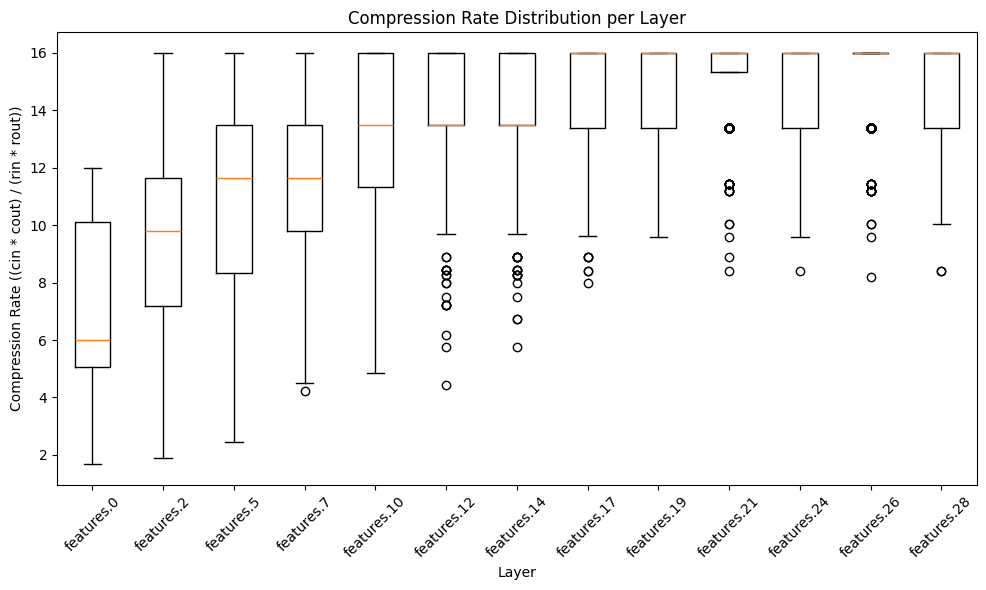

In [23]:
plot_compression_dist_boxplot(layer_dict, configs)

In [24]:
def duplicate_model(model):
    # Check if the model name is valid
    model_name = MODEL_NAME
    
    if model_name == 'vgg':
        model_cp = models.vgg16(weights=None)
        model_cp.classifier[6] = nn.Linear(4096, 10)
        
    elif model_name == 'alexnet':
        model_cp = models.alexnet(weights=None)
        model_cp.classifier[6] = nn.Linear(4096, 10)
        
    elif model_name == 'resnet':
        model_cp = models.resnet18(weights=None)
        model_cp.fc = nn.Linear(512, 10)

    model_cp.load_state_dict(model.state_dict())   
    return model_cp

In [25]:
def process_config(config, device_idx):
    try:        
        # Explicitly create a new scope to help with garbage collection
        with torch.enable_grad():

            config_str = ", ".join([f"{k}:{v}" for k, v in config.items()])
            logger.info(f"Compressing to:{config_str}")
            
            # Apply the configuration
            model.to('cpu')
            compressed_model = duplicate_model(model)
            compressed_model.to(device)

            for name, rank in config.items():
                layer = layer_info[name]['layer']
                compressed_model = replace_conv2d_with_tucker(compressed_model, name, layer, rank)

            # verify compressed model is still on gpu
            compressed_model.to(device)

            # Finetune for 3 epochs 
            if FINETUNE: 
                logger.info(f"finetuning:{config_str}")
                compressed_model = fine_tune(compressed_model, train_loader, device, epochs=3, lr=0.001)
                
            # Evaluate the model
            accuracy = calculate_accuracy(compressed_model, test_loader, device)
            params = count_parameters(compressed_model)
            flops = get_flops(compressed_model)
            inference_time = measure_inference_time(compressed_model, test_loader, device, num_runs=3)
            compression_rate = baseline_params / params if params > 0 else float('inf')
            
            result = {
                'config_str': config_str,
                'params': params,
                'flops': flops,
                'accuracy': accuracy,
                'inference_time': inference_time,
                'compression_rate': compression_rate,
                'accepted': True if accuracy >= acceptance_threshold else False
            }
            result_str = json.dumps(result, indent=4, default=str)
            logger.info(f"compressed_model:\n{result_str}")

            return result
    
    except Exception as e:
        logger.error(f"Error processing config: {config}. Error: {str(e)}")
        return None
    
    finally:
        # Explicit cleanup
        if 'compressed_model' in locals():
            del compressed_model
        
        # Clear CUDA cache
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

In [26]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import uuid


num_workers = 4
num_gpus = 1  # torch.cuda.device_count() if torch.cuda.is_available() else 0
results = []
tried_count = 0
accepted_models = []

sensitivities = precompute_sensitivities(layer_dict)
configs = generate_configs(layer_dict, sensitivities, num_cfg=500, alpha=1.0, beta=1.0)
acceptance_threshold = ACCU_RQT * baseline_accuracy

with ThreadPoolExecutor(max_workers=num_workers) as executor:
    # Submit tasks with device indices in round-robin
    if num_gpus > 0:
        futures = [executor.submit(process_config, config, 0) for config in configs] #- i % num_gpus) for i, config in enumerate(configs)]
        
        for future in as_completed(futures):
            try:
                result = future.result()
                if result is not None:
                    results.append(result)
                    
                    if result['accepted']:
                        accepted_models.append(result)
                    
                    tried_count += 1
                    if tried_count % 10 == 0:
                        logger.info(f"Evaluated {tried_count} configurations, found {len(accepted_models)} accepted models")
            
            except Exception as e:
                logger.error(f"Error in future processing: {str(e)}")
    else:
        logger.warning('NO GPU')

2025-03-30 08:23:03,371 - MainProcess - INFO - Compressing to:features.0:(2, 28), features.2:(22, 28), features.5:(22, 32), features.7:(44, 38), features.10:(32, 64), features.12:(89, 64), features.14:(64, 76), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(153, 153), features.28:(128, 128)
2025-03-30 08:23:03,372 - MainProcess - INFO - Compressing to:features.0:(2, 16), features.2:(16, 19), features.5:(28, 38), features.7:(32, 32), features.10:(32, 76), features.12:(64, 64), features.14:(64, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)
2025-03-30 08:23:03,375 - MainProcess - INFO - Compressing to:features.0:(2, 16), features.2:(16, 25), features.5:(22, 32), features.7:(32, 38), features.10:(70, 64), features.12:(64, 89), features.14:(76, 64), features.17:(64, 128), features.19:(153, 128), features.21:(128, 128), features.24:

Epoch 1/3, Loss: 0.1435
Epoch 1/3, Loss: 0.1591
Epoch 1/3, Loss: 0.1302
Epoch 1/3, Loss: 0.0627
Epoch 2/3, Loss: 0.0319
Epoch 2/3, Loss: 0.0320
Epoch 2/3, Loss: 0.0353
Epoch 2/3, Loss: 0.0256
Epoch 3/3, Loss: 0.0258
Epoch 3/3, Loss: 0.0251


2025-03-30 09:13:49,869 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(1, 25), features.2:(19, 16), features.5:(19, 32), features.7:(57, 32), features.10:(51, 76), features.12:(64, 76), features.14:(64, 64), features.17:(76, 153), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)",
    "params": 121416174,
    "flops": 4815441354,
    "accuracy": 0.9925,
    "inference_time": 0.5298755553624179,
    "compression_rate": 1.106125399734635,
    "accepted": true
}
2025-03-30 09:13:50,100 - MainProcess - INFO - Compressing to:features.0:(1, 16), features.2:(19, 16), features.5:(19, 32), features.7:(44, 32), features.10:(38, 64), features.12:(64, 76), features.14:(76, 64), features.17:(76, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 153), features.26:(128, 128), features.28:(128, 128)
2025-03-30 09:14:07,675 - MainProcess - INFO - finetuning:features.0:(1, 16), features

Epoch 3/3, Loss: 0.0265


2025-03-30 09:16:48,999 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(1, 16), features.2:(16, 16), features.5:(35, 32), features.7:(44, 32), features.10:(38, 64), features.12:(64, 64), features.14:(64, 102), features.17:(76, 128), features.19:(153, 128), features.21:(128, 179), features.24:(128, 128), features.26:(153, 128), features.28:(128, 128)",
    "params": 121565134,
    "flops": 4900492810,
    "accuracy": 0.9926,
    "inference_time": 0.43219397933619796,
    "compression_rate": 1.1047700074924443,
    "accepted": true
}
2025-03-30 09:16:49,174 - MainProcess - INFO - Compressing to:features.0:(1, 25), features.2:(22, 19), features.5:(25, 44), features.7:(51, 51), features.10:(57, 76), features.12:(64, 64), features.14:(64, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 153), features.28:(128, 128)
2025-03-30 09:17:08,856 - MainProcess - INFO - finetuning:features.0:(1, 25), featu

Epoch 3/3, Loss: 0.0201


2025-03-30 09:20:40,135 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(1, 16), features.2:(16, 16), features.5:(19, 64), features.7:(32, 44), features.10:(32, 64), features.12:(64, 64), features.14:(76, 89), features.17:(76, 128), features.19:(153, 128), features.21:(153, 153), features.24:(128, 153), features.26:(128, 128), features.28:(128, 128)",
    "params": 121566835,
    "flops": 4904639386,
    "accuracy": 0.9926,
    "inference_time": 0.4994202303025879,
    "compression_rate": 1.1047545492156639,
    "accepted": true
}
2025-03-30 09:20:40,303 - MainProcess - INFO - Compressing to:features.0:(1, 19), features.2:(28, 38), features.5:(16, 57), features.7:(32, 32), features.10:(32, 64), features.12:(64, 64), features.14:(64, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 153), features.28:(128, 128)
/home/fmokadem/miniconda3/envs/NAS/lib/python3.9/site-packages/tensorly/tenalg/svd.py

Epoch 1/3, Loss: 0.1414
Epoch 1/3, Loss: 0.1533
Epoch 2/3, Loss: 0.0333
Epoch 1/3, Loss: 0.1614
Epoch 1/3, Loss: 0.0647
Epoch 3/3, Loss: 0.0275
Epoch 2/3, Loss: 0.0324


2025-03-30 09:57:03,089 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(1, 16), features.2:(19, 16), features.5:(19, 32), features.7:(44, 32), features.10:(38, 64), features.12:(64, 76), features.14:(76, 64), features.17:(76, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 153), features.26:(128, 128), features.28:(128, 128)",
    "params": 121420990,
    "flops": 4712633866,
    "accuracy": 0.9928,
    "inference_time": 0.6536682588532725,
    "compression_rate": 1.1060815267607356,
    "accepted": true
}
2025-03-30 09:57:03,366 - MainProcess - INFO - Compressing to:features.0:(2, 16), features.2:(25, 32), features.5:(57, 96), features.7:(38, 32), features.10:(32, 64), features.12:(64, 76), features.14:(64, 76), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)
2025-03-30 09:57:24,558 - MainProcess - INFO - finetuning:features.0:(2, 16), feature

Epoch 2/3, Loss: 0.0346
Epoch 3/3, Loss: 0.0253
Epoch 1/3, Loss: 0.0645
Epoch 2/3, Loss: 0.0261


2025-03-30 10:12:03,778 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(1, 25), features.2:(22, 19), features.5:(25, 44), features.7:(51, 51), features.10:(57, 76), features.12:(64, 64), features.14:(64, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 153), features.28:(128, 128)",
    "params": 121425993,
    "flops": 5030047242,
    "accuracy": 0.991,
    "inference_time": 0.6612966323860638,
    "compression_rate": 1.106035953932862,
    "accepted": true
}
2025-03-30 10:12:03,956 - MainProcess - INFO - Compressing to:features.0:(1, 19), features.2:(16, 19), features.5:(19, 32), features.7:(32, 38), features.10:(57, 64), features.12:(89, 76), features.14:(64, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 153), features.24:(128, 128), features.26:(128, 153), features.28:(128, 128)
2025-03-30 10:12:27,892 - MainProcess - INFO - finetuning:features.0:(1, 19), features.

Epoch 3/3, Loss: 0.0270
Epoch 2/3, Loss: 0.0263


2025-03-30 10:23:44,279 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(1, 19), features.2:(28, 38), features.5:(16, 57), features.7:(32, 32), features.10:(32, 64), features.12:(64, 64), features.14:(64, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 153), features.28:(128, 128)",
    "params": 121383846,
    "flops": 5048411658,
    "accuracy": 0.9909,
    "inference_time": 0.6547147422839122,
    "compression_rate": 1.106419992657013,
    "accepted": true
}
2025-03-30 10:23:44,580 - MainProcess - INFO - Compressing to:features.0:(2, 19), features.2:(28, 16), features.5:(25, 44), features.7:(32, 38), features.10:(32, 64), features.12:(64, 64), features.14:(64, 76), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)
/home/fmokadem/miniconda3/envs/NAS/lib/python3.9/site-packages/tensorly/tenalg/svd.py:

Epoch 1/3, Loss: 0.1451
Epoch 3/3, Loss: 0.0216
Epoch 3/3, Loss: 0.0207


2025-03-30 10:37:00,680 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(2, 16), features.2:(16, 19), features.5:(19, 76), features.7:(32, 44), features.10:(44, 64), features.12:(76, 64), features.14:(64, 64), features.17:(76, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(179, 128)",
    "params": 121466873,
    "flops": 4804355594,
    "accuracy": 0.994,
    "inference_time": 0.4654957544525211,
    "compression_rate": 1.1056637145833168,
    "accepted": true
}
2025-03-30 10:37:00,904 - MainProcess - INFO - Compressing to:features.0:(2, 16), features.2:(25, 22), features.5:(22, 38), features.7:(44, 38), features.10:(32, 64), features.12:(64, 76), features.14:(64, 115), features.17:(64, 128), features.19:(153, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)
2025-03-30 10:37:20,735 - MainProcess - INFO - finetuning:features.0:(2, 16), feature

Epoch 1/3, Loss: 0.0693
Epoch 2/3, Loss: 0.0332
Epoch 1/3, Loss: 0.0719
Epoch 1/3, Loss: 0.0663
Epoch 2/3, Loss: 0.0278
Epoch 3/3, Loss: 0.0267
Epoch 2/3, Loss: 0.0277


2025-03-30 11:09:54,101 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(1, 19), features.2:(16, 19), features.5:(19, 32), features.7:(32, 38), features.10:(57, 64), features.12:(89, 76), features.14:(64, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 153), features.24:(128, 128), features.26:(128, 153), features.28:(128, 128)",
    "params": 121469450,
    "flops": 4790243594,
    "accuracy": 0.9922,
    "inference_time": 0.643545289454693,
    "compression_rate": 1.1056402576944244,
    "accepted": true
}
2025-03-30 11:09:54,357 - MainProcess - INFO - Compressing to:features.0:(1, 16), features.2:(28, 28), features.5:(25, 32), features.7:(32, 44), features.10:(38, 64), features.12:(76, 64), features.14:(89, 64), features.17:(89, 153), features.19:(128, 153), features.21:(128, 153), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)
2025-03-30 11:09:54,357 - MainProcess - INFO - Evaluated 10 configurations, found 10 a

Epoch 3/3, Loss: 0.0213
Epoch 3/3, Loss: 0.0213
Epoch 2/3, Loss: 0.0260


2025-03-30 11:22:10,737 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(2, 25), features.2:(19, 41), features.5:(16, 38), features.7:(32, 44), features.10:(32, 64), features.12:(76, 64), features.14:(64, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 179), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)",
    "params": 121435276,
    "flops": 5007744010,
    "accuracy": 0.994,
    "inference_time": 0.47041424064879206,
    "compression_rate": 1.1059514041043559,
    "accepted": true
}
2025-03-30 11:22:10,913 - MainProcess - INFO - Compressing to:features.0:(1, 25), features.2:(19, 19), features.5:(28, 38), features.7:(32, 32), features.10:(32, 64), features.12:(64, 76), features.14:(128, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 153), features.26:(128, 128), features.28:(128, 128)
2025-03-30 11:22:31,926 - MainProcess - INFO - finetuning:features.0:(1, 25), featur

Epoch 1/3, Loss: 0.1605


2025-03-30 11:25:30,948 - MainProcess - INFO - finetuning:features.0:(1, 19), features.2:(19, 16), features.5:(28, 44), features.7:(44, 44), features.10:(32, 64), features.12:(102, 64), features.14:(64, 64), features.17:(76, 128), features.19:(128, 128), features.21:(128, 128), features.24:(153, 128), features.26:(128, 128), features.28:(153, 153)
2025-03-30 11:25:34,363 - MainProcess - INFO - finetuning:features.0:(1, 22), features.2:(25, 32), features.5:(22, 44), features.7:(32, 32), features.10:(32, 64), features.12:(76, 64), features.14:(64, 64), features.17:(89, 128), features.19:(153, 128), features.21:(128, 128), features.24:(153, 128), features.26:(153, 128), features.28:(128, 128)
2025-03-30 11:25:34,643 - MainProcess - INFO - finetuning:features.0:(2, 19), features.2:(16, 25), features.5:(32, 44), features.7:(32, 38), features.10:(32, 89), features.12:(64, 64), features.14:(64, 64), features.17:(64, 128), features.19:(179, 128), features.21:(153, 128), features.24:(128, 128),

Epoch 1/3, Loss: 0.1441
Epoch 1/3, Loss: 0.0549
Epoch 1/3, Loss: 0.1483
Epoch 1/3, Loss: 0.0633


2025-03-30 11:54:41,281 - MainProcess - ERROR - Error processing config: {'features.0': (1, 16), 'features.2': (16, 19), 'features.5': (16, 32), 'features.7': (38, 44), 'features.10': (32, 64), 'features.12': (76, 76), 'features.14': (64, 64), 'features.17': (64, 128), 'features.19': (128, 128), 'features.21': (128, 153), 'features.24': (128, 128), 'features.26': (153, 128), 'features.28': (128, 128)}. Error: CUDA out of memory. Tried to allocate 784.00 MiB. GPU 0 has a total capacity of 47.54 GiB of which 633.12 MiB is free. Process 3928929 has 3.16 GiB memory in use. Process 3930001 has 6.47 GiB memory in use. Including non-PyTorch memory, this process has 37.27 GiB memory in use. Of the allocated memory 33.44 GiB is allocated by PyTorch, and 3.42 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs

Epoch 2/3, Loss: 0.0261


2025-03-30 12:05:36,151 - MainProcess - ERROR - Error processing config: {'features.0': (2, 28), 'features.2': (19, 22), 'features.5': (22, 32), 'features.7': (32, 32), 'features.10': (32, 64), 'features.12': (64, 64), 'features.14': (64, 64), 'features.17': (64, 128), 'features.19': (153, 128), 'features.21': (128, 128), 'features.24': (128, 128), 'features.26': (128, 128), 'features.28': (128, 128)}. Error: CUDA out of memory. Tried to allocate 784.00 MiB. GPU 0 has a total capacity of 47.54 GiB of which 121.12 MiB is free. Process 3928929 has 3.16 GiB memory in use. Process 3930001 has 6.10 GiB memory in use. Including non-PyTorch memory, this process has 38.14 GiB memory in use. Of the allocated memory 33.56 GiB is allocated by PyTorch, and 4.18 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs

Epoch 2/3, Loss: 0.0259


2025-03-30 12:08:54,132 - MainProcess - ERROR - Error processing config: {'features.0': (1, 22), 'features.2': (16, 48), 'features.5': (32, 32), 'features.7': (32, 51), 'features.10': (32, 76), 'features.12': (102, 102), 'features.14': (64, 64), 'features.17': (64, 128), 'features.19': (128, 128), 'features.21': (128, 128), 'features.24': (128, 153), 'features.26': (128, 128), 'features.28': (128, 128)}. Error: CUDA out of memory. Tried to allocate 784.00 MiB. GPU 0 has a total capacity of 47.54 GiB of which 569.12 MiB is free. Process 3928929 has 3.16 GiB memory in use. Process 3930001 has 6.29 GiB memory in use. Including non-PyTorch memory, this process has 37.51 GiB memory in use. Of the allocated memory 33.56 GiB is allocated by PyTorch, and 3.54 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/do

Epoch 2/3, Loss: 0.0325
Epoch 1/3, Loss: 0.0690
Epoch 1/3, Loss: 0.1547
Epoch 3/3, Loss: 0.0215
Epoch 3/3, Loss: 0.0274


2025-03-30 12:32:27,457 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(2, 19), features.2:(16, 19), features.5:(16, 44), features.7:(44, 32), features.10:(57, 64), features.12:(64, 64), features.14:(76, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 153), features.24:(153, 128), features.26:(128, 128), features.28:(128, 128)",
    "params": 121449785,
    "flops": 4768078346,
    "accuracy": 0.9937,
    "inference_time": 0.6054707864287553,
    "compression_rate": 1.1058192816067973,
    "accepted": true
}
2025-03-30 12:32:27,742 - MainProcess - INFO - Compressing to:features.0:(2, 16), features.2:(16, 22), features.5:(19, 32), features.7:(32, 32), features.10:(38, 102), features.12:(64, 64), features.14:(64, 64), features.17:(76, 128), features.19:(128, 128), features.21:(153, 128), features.24:(128, 128), features.26:(153, 128), features.28:(128, 128)
2025-03-30 12:32:49,738 - MainProcess - INFO - finetuning:features.0:(2, 16), featur

Epoch 2/3, Loss: 0.0270


2025-03-30 12:38:06,833 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(1, 22), features.2:(19, 19), features.5:(16, 32), features.7:(57, 44), features.10:(51, 76), features.12:(64, 64), features.14:(64, 64), features.17:(64, 128), features.19:(128, 153), features.21:(128, 128), features.24:(128, 153), features.26:(128, 128), features.28:(128, 128)",
    "params": 121453071,
    "flops": 4907028234,
    "accuracy": 0.9914,
    "inference_time": 0.6317723961645884,
    "compression_rate": 1.1057893628725124,
    "accepted": true
}
2025-03-30 12:38:07,026 - MainProcess - INFO - Compressing to:features.0:(1, 35), features.2:(19, 25), features.5:(25, 32), features.7:(32, 44), features.10:(44, 76), features.12:(76, 64), features.14:(64, 76), features.17:(89, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(153, 128), features.28:(128, 128)
/home/fmokadem/miniconda3/envs/NAS/lib/python3.9/site-packages/tensorly/tenalg/svd.py

Epoch 2/3, Loss: 0.0324
Epoch 3/3, Loss: 0.0214


2025-03-30 12:47:28,669 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(2, 19), features.2:(32, 19), features.5:(25, 32), features.7:(32, 44), features.10:(38, 64), features.12:(64, 64), features.14:(64, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 153), features.26:(128, 128), features.28:(128, 128)",
    "params": 121387401,
    "flops": 4858896906,
    "accuracy": 0.9929,
    "inference_time": 0.4065283129422781,
    "compression_rate": 1.1063875895983637,
    "accepted": true
}
2025-03-30 12:47:28,836 - MainProcess - INFO - Compressing to:features.0:(2, 19), features.2:(22, 32), features.5:(25, 44), features.7:(32, 38), features.10:(32, 89), features.12:(76, 64), features.14:(64, 76), features.17:(89, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)


Epoch 1/3, Loss: 0.0644


2025-03-30 12:47:45,605 - MainProcess - INFO - finetuning:features.0:(2, 19), features.2:(22, 32), features.5:(25, 44), features.7:(32, 38), features.10:(32, 89), features.12:(76, 64), features.14:(64, 76), features.17:(89, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)


Epoch 3/3, Loss: 0.0262
Epoch 1/3, Loss: 0.1487


2025-03-30 12:52:49,768 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(1, 25), features.2:(16, 16), features.5:(35, 32), features.7:(38, 38), features.10:(32, 64), features.12:(89, 64), features.14:(89, 76), features.17:(64, 128), features.19:(128, 153), features.21:(128, 128), features.24:(128, 128), features.26:(128, 153), features.28:(128, 153)",
    "params": 121519902,
    "flops": 4885954314,
    "accuracy": 0.9919,
    "inference_time": 0.31090229534546027,
    "compression_rate": 1.1051812237307432,
    "accepted": true
}
2025-03-30 12:52:49,947 - MainProcess - INFO - Compressing to:features.0:(2, 19), features.2:(48, 16), features.5:(28, 38), features.7:(38, 32), features.10:(44, 64), features.12:(76, 64), features.14:(64, 64), features.17:(76, 128), features.19:(128, 128), features.21:(128, 128), features.24:(153, 128), features.26:(128, 128), features.28:(128, 128)
2025-03-30 12:53:05,721 - MainProcess - INFO - finetuning:features.0:(2, 19), featur

Epoch 1/3, Loss: 0.0640
Epoch 2/3, Loss: 0.0264
Epoch 2/3, Loss: 0.0260
Epoch 2/3, Loss: 0.0326
Epoch 1/3, Loss: 0.0583
Epoch 3/3, Loss: 0.0201
Epoch 3/3, Loss: 0.0206


2025-03-30 13:07:39,794 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(2, 19), features.2:(22, 32), features.5:(25, 44), features.7:(32, 38), features.10:(32, 89), features.12:(76, 64), features.14:(64, 76), features.17:(89, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)",
    "params": 121414805,
    "flops": 5028115466,
    "accuracy": 0.9937,
    "inference_time": 0.2462309054761429,
    "compression_rate": 1.1061378717364823,
    "accepted": true
}
2025-03-30 13:07:39,999 - MainProcess - INFO - Compressing to:features.0:(1, 16), features.2:(16, 19), features.5:(16, 32), features.7:(32, 32), features.10:(51, 76), features.12:(64, 64), features.14:(76, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)
2025-03-30 13:07:55,679 - MainProcess - INFO - finetuning:features.0:(1, 16), feature

Epoch 2/3, Loss: 0.0259


2025-03-30 13:09:35,721 - MainProcess - INFO - finetuning:features.0:(2, 22), features.2:(19, 35), features.5:(16, 32), features.7:(57, 38), features.10:(32, 64), features.12:(64, 64), features.14:(64, 76), features.17:(64, 128), features.19:(128, 153), features.21:(128, 128), features.24:(128, 128), features.26:(128, 153), features.28:(128, 128)


Epoch 3/3, Loss: 0.0263
Epoch 1/3, Loss: 0.1297


2025-03-30 13:15:17,975 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(1, 35), features.2:(19, 25), features.5:(25, 32), features.7:(32, 44), features.10:(44, 76), features.12:(76, 64), features.14:(64, 76), features.17:(89, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(153, 128), features.28:(128, 128)",
    "params": 121458513,
    "flops": 4902399498,
    "accuracy": 0.9913,
    "inference_time": 0.3103430301520475,
    "compression_rate": 1.1057398175128326,
    "accepted": true
}
2025-03-30 13:15:18,112 - MainProcess - INFO - Compressing to:features.0:(1, 16), features.2:(35, 16), features.5:(22, 32), features.7:(38, 51), features.10:(57, 76), features.12:(102, 64), features.14:(64, 64), features.17:(76, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)
2025-03-30 13:15:34,095 - MainProcess - INFO - finetuning:features.0:(1, 16), featur

Epoch 2/3, Loss: 0.0342
Epoch 3/3, Loss: 0.0207
Epoch 1/3, Loss: 0.0686


2025-03-30 13:22:04,293 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(2, 19), features.2:(48, 16), features.5:(28, 38), features.7:(38, 32), features.10:(44, 64), features.12:(76, 64), features.14:(64, 64), features.17:(76, 128), features.19:(128, 128), features.21:(128, 128), features.24:(153, 128), features.26:(128, 128), features.28:(128, 128)",
    "params": 121425265,
    "flops": 5043644938,
    "accuracy": 0.9939,
    "inference_time": 0.31146830054605085,
    "compression_rate": 1.1060425851242737,
    "accepted": true
}
2025-03-30 13:22:04,449 - MainProcess - INFO - Compressing to:features.0:(1, 19), features.2:(22, 16), features.5:(28, 38), features.7:(32, 32), features.10:(38, 64), features.12:(76, 89), features.14:(64, 64), features.17:(76, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)
2025-03-30 13:22:04,449 - MainProcess - INFO - Evaluated 20 configurations, found 20

Epoch 3/3, Loss: 0.0267
Epoch 1/3, Loss: 0.1336


2025-03-30 13:26:55,918 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(1, 16), features.2:(16, 19), features.5:(16, 32), features.7:(32, 32), features.10:(51, 76), features.12:(64, 64), features.14:(76, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)",
    "params": 121361058,
    "flops": 4635249930,
    "accuracy": 0.993,
    "inference_time": 0.30927536391402,
    "compression_rate": 1.1066277454502744,
    "accepted": true
}
2025-03-30 13:26:56,069 - MainProcess - INFO - Compressing to:features.0:(1, 16), features.2:(22, 16), features.5:(16, 38), features.7:(38, 32), features.10:(44, 64), features.12:(64, 76), features.14:(64, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)
2025-03-30 13:27:12,794 - MainProcess - INFO - finetuning:features.0:(1, 16), features.2

Epoch 2/3, Loss: 0.0267
Epoch 1/3, Loss: 0.1336
Epoch 1/3, Loss: 0.1349
Epoch 2/3, Loss: 0.0327
Epoch 2/3, Loss: 0.0332
Epoch 3/3, Loss: 0.0217
Epoch 2/3, Loss: 0.0334


2025-03-30 13:41:13,835 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(2, 22), features.2:(19, 35), features.5:(16, 32), features.7:(57, 38), features.10:(32, 64), features.12:(64, 64), features.14:(64, 76), features.17:(64, 128), features.19:(128, 153), features.21:(128, 128), features.24:(128, 128), features.26:(128, 153), features.28:(128, 128)",
    "params": 121440208,
    "flops": 5011657738,
    "accuracy": 0.9939,
    "inference_time": 0.30227054911813916,
    "compression_rate": 1.1059064885659615,
    "accepted": true
}
2025-03-30 13:41:13,992 - MainProcess - INFO - Compressing to:features.0:(1, 16), features.2:(16, 51), features.5:(19, 32), features.7:(64, 32), features.10:(32, 76), features.12:(64, 64), features.14:(64, 76), features.17:(76, 128), features.19:(153, 128), features.21:(128, 128), features.24:(153, 128), features.26:(128, 128), features.28:(128, 128)
2025-03-30 13:41:30,785 - MainProcess - INFO - finetuning:features.0:(1, 16), featur

Epoch 3/3, Loss: 0.0270
Epoch 3/3, Loss: 0.0268
Epoch 3/3, Loss: 0.0258


2025-03-30 13:46:41,505 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(1, 16), features.2:(22, 16), features.5:(16, 38), features.7:(38, 32), features.10:(44, 64), features.12:(64, 76), features.14:(64, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)",
    "params": 121352558,
    "flops": 4673170442,
    "accuracy": 0.9901,
    "inference_time": 0.23496502169631342,
    "compression_rate": 1.1067052579147116,
    "accepted": true
}
2025-03-30 13:46:41,666 - MainProcess - INFO - Compressing to:features.0:(1, 19), features.2:(19, 16), features.5:(16, 51), features.7:(32, 51), features.10:(32, 76), features.12:(64, 64), features.14:(64, 76), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(153, 128), features.26:(128, 128), features.28:(128, 128)
2025-03-30 13:46:57,785 - MainProcess - INFO - finetuning:features.0:(1, 19), featur

Epoch 1/3, Loss: 0.1372
Epoch 1/3, Loss: 0.1873
Epoch 1/3, Loss: 0.0654
Epoch 2/3, Loss: 0.0358
Epoch 2/3, Loss: 0.0330
Epoch 1/3, Loss: 0.0603
Epoch 3/3, Loss: 0.0276
Epoch 2/3, Loss: 0.0257


2025-03-30 14:08:34,521 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(1, 19), features.2:(19, 16), features.5:(16, 51), features.7:(32, 51), features.10:(32, 76), features.12:(64, 64), features.14:(64, 76), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(153, 128), features.26:(128, 128), features.28:(128, 128)",
    "params": 121396654,
    "flops": 4736116234,
    "accuracy": 0.9923,
    "inference_time": 0.47069007474652275,
    "compression_rate": 1.1063032593962598,
    "accepted": true
}
2025-03-30 14:08:34,759 - MainProcess - INFO - Compressing to:features.0:(1, 19), features.2:(32, 22), features.5:(19, 38), features.7:(51, 57), features.10:(32, 128), features.12:(64, 76), features.14:(64, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)
2025-03-30 14:08:57,274 - MainProcess - INFO - finetuning:features.0:(1, 19), featu

Epoch 3/3, Loss: 0.0250
Epoch 2/3, Loss: 0.0256


2025-03-30 14:16:17,216 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(1, 16), features.2:(16, 51), features.5:(19, 32), features.7:(64, 32), features.10:(32, 76), features.12:(64, 64), features.14:(64, 76), features.17:(76, 128), features.19:(153, 128), features.21:(128, 128), features.24:(153, 128), features.26:(128, 128), features.28:(128, 128)",
    "params": 121467582,
    "flops": 5152275978,
    "accuracy": 0.9933,
    "inference_time": 0.4481077199275833,
    "compression_rate": 1.1056572608813435,
    "accepted": true
}
2025-03-30 14:16:17,343 - MainProcess - INFO - Compressing to:features.0:(1, 16), features.2:(19, 16), features.5:(25, 38), features.7:(38, 32), features.10:(32, 76), features.12:(76, 64), features.14:(64, 64), features.17:(64, 128), features.19:(153, 128), features.21:(128, 128), features.24:(153, 128), features.26:(128, 128), features.28:(128, 128)


Epoch 3/3, Loss: 0.0210


2025-03-30 14:16:37,867 - MainProcess - INFO - finetuning:features.0:(1, 16), features.2:(19, 16), features.5:(25, 38), features.7:(38, 32), features.10:(32, 76), features.12:(76, 64), features.14:(64, 64), features.17:(64, 128), features.19:(153, 128), features.21:(128, 128), features.24:(153, 128), features.26:(128, 128), features.28:(128, 128)


Epoch 1/3, Loss: 0.1701


2025-03-30 14:20:11,478 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(2, 19), features.2:(19, 22), features.5:(32, 51), features.7:(32, 32), features.10:(32, 64), features.12:(64, 64), features.14:(64, 64), features.17:(64, 128), features.19:(153, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)",
    "params": 121384667,
    "flops": 4807591946,
    "accuracy": 0.9943,
    "inference_time": 0.35144321174378607,
    "compression_rate": 1.1064125092504475,
    "accepted": true
}
2025-03-30 14:20:11,722 - MainProcess - INFO - Compressing to:features.0:(2, 28), features.2:(25, 19), features.5:(28, 32), features.7:(32, 32), features.10:(32, 64), features.12:(76, 76), features.14:(64, 64), features.17:(76, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)
2025-03-30 14:20:47,495 - MainProcess - INFO - finetuning:features.0:(2, 28), featur

Epoch 1/3, Loss: 0.0699
Epoch 1/3, Loss: 0.1803
Epoch 1/3, Loss: 0.1517
Epoch 1/3, Loss: 0.0594
Epoch 2/3, Loss: 0.0265
Epoch 2/3, Loss: 0.0360
Epoch 2/3, Loss: 0.0330
Epoch 3/3, Loss: 0.0210
Epoch 2/3, Loss: 0.0248


2025-03-30 15:02:12,532 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(2, 44), features.2:(22, 22), features.5:(19, 32), features.7:(32, 32), features.10:(32, 64), features.12:(64, 64), features.14:(64, 64), features.17:(76, 128), features.19:(128, 153), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)",
    "params": 121393325,
    "flops": 2189062154,
    "accuracy": 0.9923,
    "inference_time": 0.2854183180823195,
    "compression_rate": 1.1063335978316764,
    "accepted": true
}
2025-03-30 15:02:12,879 - MainProcess - INFO - Compressing to:features.0:(1, 16), features.2:(16, 19), features.5:(16, 32), features.7:(38, 32), features.10:(32, 64), features.12:(64, 64), features.14:(64, 76), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)
2025-03-30 15:02:30,000 - MainProcess - INFO - finetuning:features.0:(1, 16), feature

Epoch 3/3, Loss: 0.0276
Epoch 3/3, Loss: 0.0261


2025-03-30 15:06:54,780 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(1, 19), features.2:(19, 19), features.5:(16, 32), features.7:(32, 44), features.10:(32, 89), features.12:(64, 64), features.14:(64, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)",
    "params": 121344319,
    "flops": 4662884362,
    "accuracy": 0.9904,
    "inference_time": 0.2681860903519227,
    "compression_rate": 1.1067804006547681,
    "accepted": true
}
2025-03-30 15:06:54,936 - MainProcess - INFO - Compressing to:features.0:(2, 22), features.2:(16, 22), features.5:(28, 32), features.7:(32, 44), features.10:(38, 64), features.12:(64, 64), features.14:(89, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 204), features.26:(128, 128), features.28:(128, 128)
2025-03-30 15:06:54,936 - MainProcess - INFO - Evaluated 30 configurations, found 30 

Epoch 3/3, Loss: 0.0207
Epoch 1/3, Loss: 0.1562


2025-03-30 15:09:17,617 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(1, 19), features.2:(22, 28), features.5:(16, 44), features.7:(32, 38), features.10:(51, 64), features.12:(64, 64), features.14:(64, 64), features.17:(64, 153), features.19:(153, 128), features.21:(128, 153), features.24:(153, 128), features.26:(153, 153), features.28:(128, 153)",
    "params": 121628815,
    "flops": 4920965806,
    "accuracy": 0.9924,
    "inference_time": 0.2571086883544922,
    "compression_rate": 1.1041915848641624,
    "accepted": true
}
2025-03-30 15:09:17,744 - MainProcess - INFO - Compressing to:features.0:(1, 19), features.2:(22, 19), features.5:(19, 38), features.7:(32, 38), features.10:(32, 64), features.12:(64, 64), features.14:(76, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)
2025-03-30 15:09:35,288 - MainProcess - INFO - finetuning:features.0:(1, 19), feature

Epoch 1/3, Loss: 0.0669
Epoch 2/3, Loss: 0.0350
Epoch 1/3, Loss: 0.1589
Epoch 3/3, Loss: 0.0269
Epoch 1/3, Loss: 0.0621
Epoch 2/3, Loss: 0.0263


2025-03-30 15:24:20,864 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(1, 16), features.2:(16, 19), features.5:(16, 32), features.7:(38, 32), features.10:(32, 64), features.12:(64, 64), features.14:(64, 76), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)",
    "params": 121340702,
    "flops": 4594895882,
    "accuracy": 0.9899,
    "inference_time": 0.2814407637164851,
    "compression_rate": 1.106813392261403,
    "accepted": true
}
2025-03-30 15:24:21,006 - MainProcess - INFO - Compressing to:features.0:(1, 16), features.2:(19, 25), features.5:(22, 32), features.7:(32, 32), features.10:(32, 64), features.12:(76, 64), features.14:(64, 76), features.17:(76, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(153, 128), features.28:(153, 128)
2025-03-30 15:24:38,182 - MainProcess - INFO - finetuning:features.0:(1, 16), features

Epoch 2/3, Loss: 0.0350
Epoch 3/3, Loss: 0.0214
Epoch 1/3, Loss: 0.1592
Epoch 2/3, Loss: 0.0258


2025-03-30 15:33:44,995 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(2, 22), features.2:(16, 22), features.5:(28, 32), features.7:(32, 44), features.10:(38, 64), features.12:(64, 64), features.14:(89, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 204), features.26:(128, 128), features.28:(128, 128)",
    "params": 121491177,
    "flops": 3538116618,
    "accuracy": 0.992,
    "inference_time": 0.25764030357328443,
    "compression_rate": 1.1054425293780799,
    "accepted": true
}
2025-03-30 15:33:45,146 - MainProcess - INFO - Compressing to:features.0:(2, 16), features.2:(16, 16), features.5:(38, 89), features.7:(38, 32), features.10:(38, 64), features.12:(76, 64), features.14:(64, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 153), features.28:(153, 128)
2025-03-30 15:34:04,334 - MainProcess - INFO - finetuning:features.0:(2, 16), feature

Epoch 3/3, Loss: 0.0278
Epoch 2/3, Loss: 0.0322


2025-03-30 15:38:22,861 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(1, 19), features.2:(22, 19), features.5:(19, 38), features.7:(32, 38), features.10:(32, 64), features.12:(64, 64), features.14:(76, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)",
    "params": 121344770,
    "flops": 2177619466,
    "accuracy": 0.9913,
    "inference_time": 0.28572214889931324,
    "compression_rate": 1.1067762871032678,
    "accepted": true
}
2025-03-30 15:38:23,028 - MainProcess - INFO - Compressing to:features.0:(2, 19), features.2:(25, 16), features.5:(19, 32), features.7:(44, 44), features.10:(32, 76), features.12:(64, 64), features.14:(76, 64), features.17:(64, 128), features.19:(153, 128), features.21:(128, 128), features.24:(128, 128), features.26:(153, 128), features.28:(128, 128)
2025-03-30 15:38:40,200 - MainProcess - INFO - finetuning:features.0:(2, 19), featur

Epoch 3/3, Loss: 0.0209
Epoch 1/3, Loss: 0.0614


2025-03-30 15:42:24,079 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(2, 16), features.2:(38, 28), features.5:(19, 51), features.7:(32, 32), features.10:(38, 76), features.12:(76, 64), features.14:(89, 76), features.17:(89, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)",
    "params": 121438550,
    "flops": 5253531146,
    "accuracy": 0.9937,
    "inference_time": 0.2823080490096106,
    "compression_rate": 1.105921587502486,
    "accepted": true
}
2025-03-30 15:42:24,237 - MainProcess - INFO - Compressing to:features.0:(1, 16), features.2:(16, 16), features.5:(16, 57), features.7:(44, 32), features.10:(32, 76), features.12:(64, 64), features.14:(64, 76), features.17:(64, 128), features.19:(128, 128), features.21:(128, 153), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)
2025-03-30 15:42:41,826 - MainProcess - INFO - finetuning:features.0:(1, 16), features

Epoch 3/3, Loss: 0.0267
Epoch 1/3, Loss: 0.0670


2025-03-30 15:47:09,948 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(1, 16), features.2:(19, 25), features.5:(22, 32), features.7:(32, 32), features.10:(32, 64), features.12:(76, 64), features.14:(64, 76), features.17:(76, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(153, 128), features.28:(153, 128)",
    "params": 121455969,
    "flops": 4764290058,
    "accuracy": 0.9914,
    "inference_time": 0.284872288916521,
    "compression_rate": 1.10576297818677,
    "accepted": true
}
2025-03-30 15:47:10,165 - MainProcess - INFO - Compressing to:features.0:(2, 25), features.2:(22, 22), features.5:(28, 38), features.7:(32, 44), features.10:(32, 89), features.12:(64, 102), features.14:(64, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 153), features.24:(153, 128), features.26:(128, 128), features.28:(128, 128)
2025-03-30 15:47:27,344 - MainProcess - INFO - finetuning:features.0:(2, 25), features.

Epoch 2/3, Loss: 0.0266
Epoch 1/3, Loss: 0.1744
Epoch 1/3, Loss: 0.0686
Epoch 2/3, Loss: 0.0254
Epoch 3/3, Loss: 0.0208
Epoch 2/3, Loss: 0.0257


2025-03-30 16:00:45,690 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(2, 16), features.2:(16, 16), features.5:(38, 89), features.7:(38, 32), features.10:(38, 64), features.12:(76, 64), features.14:(64, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 153), features.28:(153, 128)",
    "params": 121450505,
    "flops": 3616943114,
    "accuracy": 0.9919,
    "inference_time": 0.29255039524880183,
    "compression_rate": 1.105812725933087,
    "accepted": true
}
2025-03-30 16:00:45,847 - MainProcess - INFO - Compressing to:features.0:(2, 25), features.2:(32, 16), features.5:(22, 38), features.7:(44, 32), features.10:(32, 64), features.12:(64, 64), features.14:(64, 64), features.17:(89, 128), features.19:(128, 153), features.21:(153, 153), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)
2025-03-30 16:01:03,365 - MainProcess - INFO - finetuning:features.0:(2, 25), feature

Epoch 2/3, Loss: 0.0351
Epoch 3/3, Loss: 0.0198
Epoch 3/3, Loss: 0.0220


2025-03-30 16:07:08,803 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(2, 19), features.2:(25, 16), features.5:(19, 32), features.7:(44, 44), features.10:(32, 76), features.12:(64, 64), features.14:(76, 64), features.17:(64, 128), features.19:(153, 128), features.21:(128, 128), features.24:(128, 128), features.26:(153, 128), features.28:(128, 128)",
    "params": 121440265,
    "flops": 4829370890,
    "accuracy": 0.9939,
    "inference_time": 0.24605820133427903,
    "compression_rate": 1.1059059694904323,
    "accepted": true
}
2025-03-30 16:07:08,964 - MainProcess - INFO - Compressing to:features.0:(2, 28), features.2:(19, 28), features.5:(16, 32), features.7:(38, 32), features.10:(32, 64), features.12:(64, 64), features.14:(64, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)
2025-03-30 16:07:26,092 - MainProcess - INFO - finetuning:features.0:(2, 28), featur

Epoch 1/3, Loss: 0.0622


2025-03-30 16:09:21,749 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(2, 25), features.2:(22, 22), features.5:(28, 38), features.7:(32, 44), features.10:(32, 89), features.12:(64, 102), features.14:(64, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 153), features.24:(153, 128), features.26:(128, 128), features.28:(128, 128)",
    "params": 121467605,
    "flops": 2446690826,
    "accuracy": 0.9917,
    "inference_time": 0.2666582393038804,
    "compression_rate": 1.1056570515241493,
    "accepted": true
}
2025-03-30 16:09:21,887 - MainProcess - INFO - Compressing to:features.0:(2, 22), features.2:(19, 22), features.5:(16, 44), features.7:(32, 32), features.10:(38, 64), features.12:(76, 64), features.14:(76, 76), features.17:(64, 128), features.19:(128, 128), features.21:(153, 128), features.24:(153, 128), features.26:(128, 128), features.28:(128, 128)
2025-03-30 16:09:21,888 - MainProcess - INFO - Evaluated 40 configurations, found 40

Epoch 3/3, Loss: 0.0275


2025-03-30 16:13:12,352 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(1, 16), features.2:(16, 16), features.5:(16, 57), features.7:(44, 32), features.10:(32, 76), features.12:(64, 64), features.14:(64, 76), features.17:(64, 128), features.19:(128, 128), features.21:(128, 153), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)",
    "params": 121394366,
    "flops": 4708393994,
    "accuracy": 0.9912,
    "inference_time": 0.30299731374040023,
    "compression_rate": 1.106324110626353,
    "accepted": true
}
2025-03-30 16:13:12,481 - MainProcess - INFO - Compressing to:features.0:(1, 25), features.2:(16, 19), features.5:(19, 51), features.7:(32, 32), features.10:(32, 64), features.12:(76, 76), features.14:(64, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 153), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)
2025-03-30 16:13:26,230 - MainProcess - INFO - finetuning:features.0:(1, 25), feature

Epoch 1/3, Loss: 0.0706


2025-03-30 16:15:04,669 - MainProcess - INFO - finetuning:features.0:(2, 19), features.2:(25, 16), features.5:(25, 32), features.7:(38, 32), features.10:(32, 64), features.12:(64, 76), features.14:(64, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(153, 179), features.26:(128, 128), features.28:(128, 128)
2025-03-30 16:15:10,987 - MainProcess - ERROR - Error processing config: {'features.0': (2, 28), 'features.2': (19, 28), 'features.5': (16, 32), 'features.7': (38, 32), 'features.10': (32, 64), 'features.12': (64, 64), 'features.14': (64, 64), 'features.17': (64, 128), 'features.19': (128, 128), 'features.21': (128, 128), 'features.24': (128, 128), 'features.26': (128, 128), 'features.28': (128, 128)}. Error: CUDA out of memory. Tried to allocate 98.00 MiB. GPU 0 has a total capacity of 47.54 GiB of which 36.31 MiB is free. Process 3928929 has 3.16 GiB memory in use. Process 3930001 has 764.00 MiB memory in use. Including non-PyTorch memory, t

Epoch 1/3, Loss: 0.1882
Epoch 1/3, Loss: 0.0688
Epoch 1/3, Loss: 0.1427
Epoch 1/3, Loss: 0.1710
Epoch 2/3, Loss: 0.0348
Epoch 2/3, Loss: 0.0260
Epoch 2/3, Loss: 0.0327
Epoch 3/3, Loss: 0.0275
Epoch 2/3, Loss: 0.0332


2025-03-30 16:50:14,838 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(1, 16), features.2:(35, 25), features.5:(16, 32), features.7:(44, 44), features.10:(38, 89), features.12:(64, 64), features.14:(64, 102), features.17:(89, 128), features.19:(128, 128), features.21:(128, 153), features.24:(128, 128), features.26:(128, 153), features.28:(128, 128)",
    "params": 121519399,
    "flops": 3975996298,
    "accuracy": 0.9928,
    "inference_time": 0.2731896737578568,
    "compression_rate": 1.1051857983596511,
    "accepted": true
}
2025-03-30 16:50:15,078 - MainProcess - INFO - Compressing to:features.0:(1, 16), features.2:(25, 51), features.5:(25, 32), features.7:(44, 44), features.10:(32, 64), features.12:(76, 64), features.14:(64, 64), features.17:(64, 153), features.19:(128, 128), features.21:(153, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)
2025-03-30 16:50:32,189 - MainProcess - INFO - finetuning:features.0:(1, 16), featur

Epoch 3/3, Loss: 0.0276
Epoch 3/3, Loss: 0.0216


2025-03-30 16:54:29,896 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(1, 22), features.2:(22, 19), features.5:(28, 51), features.7:(38, 32), features.10:(32, 76), features.12:(76, 64), features.14:(64, 76), features.17:(76, 153), features.19:(128, 128), features.21:(153, 128), features.24:(128, 128), features.26:(128, 153), features.28:(128, 128)",
    "params": 121494752,
    "flops": 3664444106,
    "accuracy": 0.9915,
    "inference_time": 0.2323692462499987,
    "compression_rate": 1.1054100015776813,
    "accepted": true
}
2025-03-30 16:54:30,105 - MainProcess - INFO - Compressing to:features.0:(2, 19), features.2:(35, 25), features.5:(16, 44), features.7:(38, 44), features.10:(32, 64), features.12:(140, 76), features.14:(76, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(179, 128), features.26:(153, 128), features.28:(128, 128)
2025-03-30 16:54:47,393 - MainProcess - INFO - finetuning:features.0:(2, 19), featur

Epoch 3/3, Loss: 0.0261
Epoch 1/3, Loss: 0.1928


2025-03-30 17:00:10,666 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(1, 44), features.2:(32, 25), features.5:(28, 32), features.7:(32, 32), features.10:(32, 64), features.12:(64, 64), features.14:(64, 76), features.17:(64, 153), features.19:(128, 128), features.21:(128, 153), features.24:(179, 179), features.26:(128, 128), features.28:(128, 128)",
    "params": 121604607,
    "flops": 5007615630,
    "accuracy": 0.9921,
    "inference_time": 0.29172804704896965,
    "compression_rate": 1.104411397834623,
    "accepted": true
}
2025-03-30 17:00:10,859 - MainProcess - INFO - Compressing to:features.0:(2, 19), features.2:(35, 28), features.5:(35, 32), features.7:(32, 32), features.10:(44, 64), features.12:(64, 64), features.14:(64, 64), features.17:(76, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)
2025-03-30 17:00:29,899 - MainProcess - INFO - finetuning:features.0:(2, 19), feature

Epoch 1/3, Loss: 0.0604
Epoch 2/3, Loss: 0.0354
Epoch 1/3, Loss: 0.1457
Epoch 3/3, Loss: 0.0264
Epoch 1/3, Loss: 0.0630
Epoch 2/3, Loss: 0.0252


2025-03-30 17:14:00,895 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(1, 16), features.2:(25, 51), features.5:(25, 32), features.7:(44, 44), features.10:(32, 64), features.12:(76, 64), features.14:(64, 64), features.17:(64, 153), features.19:(128, 128), features.21:(153, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)",
    "params": 121426993,
    "flops": 5371118602,
    "accuracy": 0.9907,
    "inference_time": 0.31366362035147954,
    "compression_rate": 1.1060268452830748,
    "accepted": true
}
2025-03-30 17:14:01,048 - MainProcess - INFO - Compressing to:features.0:(2, 22), features.2:(19, 25), features.5:(22, 32), features.7:(32, 32), features.10:(64, 64), features.12:(64, 64), features.14:(64, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(153, 153), features.26:(128, 153), features.28:(128, 128)


Epoch 2/3, Loss: 0.0318


2025-03-30 17:14:19,003 - MainProcess - INFO - finetuning:features.0:(2, 22), features.2:(19, 25), features.5:(22, 32), features.7:(32, 32), features.10:(64, 64), features.12:(64, 64), features.14:(64, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(153, 153), features.26:(128, 153), features.28:(128, 128)


Epoch 1/3, Loss: 0.0618
Epoch 3/3, Loss: 0.0205
Epoch 2/3, Loss: 0.0262


2025-03-30 17:23:15,815 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(2, 19), features.2:(35, 25), features.5:(16, 44), features.7:(38, 44), features.10:(32, 64), features.12:(140, 76), features.14:(76, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(179, 128), features.26:(153, 128), features.28:(128, 128)",
    "params": 121563556,
    "flops": 5319788554,
    "accuracy": 0.992,
    "inference_time": 0.31464194087212766,
    "compression_rate": 1.1047843483617739,
    "accepted": true
}
2025-03-30 17:23:15,972 - MainProcess - INFO - Compressing to:features.0:(2, 19), features.2:(35, 19), features.5:(19, 38), features.7:(32, 32), features.10:(32, 64), features.12:(64, 64), features.14:(76, 64), features.17:(102, 179), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)
2025-03-30 17:23:30,247 - MainProcess - INFO - finetuning:features.0:(2, 19), featu

Epoch 3/3, Loss: 0.0261
Epoch 2/3, Loss: 0.0258


2025-03-30 17:27:07,343 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(1, 16), features.2:(22, 16), features.5:(22, 38), features.7:(57, 38), features.10:(32, 64), features.12:(76, 89), features.14:(76, 64), features.17:(64, 128), features.19:(128, 153), features.21:(128, 128), features.24:(153, 128), features.26:(128, 128), features.28:(128, 128)",
    "params": 121473828,
    "flops": 4970400522,
    "accuracy": 0.9912,
    "inference_time": 0.3132716728623505,
    "compression_rate": 1.1056004096619068,
    "accepted": true
}
2025-03-30 17:27:07,492 - MainProcess - INFO - Compressing to:features.0:(2, 41), features.2:(22, 32), features.5:(19, 32), features.7:(44, 32), features.10:(44, 64), features.12:(64, 64), features.14:(64, 64), features.17:(76, 153), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)
2025-03-30 17:27:21,728 - MainProcess - INFO - finetuning:features.0:(2, 41), feature

Epoch 3/3, Loss: 0.0201
Epoch 1/3, Loss: 0.0659
Epoch 3/3, Loss: 0.0216


2025-03-30 17:32:50,002 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(2, 22), features.2:(19, 25), features.5:(22, 32), features.7:(32, 32), features.10:(64, 64), features.12:(64, 64), features.14:(64, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(153, 153), features.26:(128, 153), features.28:(128, 128)",
    "params": 121489973,
    "flops": 4783330478,
    "accuracy": 0.9877,
    "inference_time": 0.2691335212399752,
    "compression_rate": 1.105453484626258,
    "accepted": true
}
2025-03-30 17:32:50,140 - MainProcess - INFO - Compressing to:features.0:(1, 16), features.2:(19, 19), features.5:(28, 38), features.7:(51, 32), features.10:(38, 115), features.12:(64, 64), features.14:(64, 76), features.17:(89, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)
2025-03-30 17:33:03,728 - MainProcess - INFO - finetuning:features.0:(1, 16), feature

Epoch 1/3, Loss: 0.0651
Epoch 1/3, Loss: 0.1332
Epoch 2/3, Loss: 0.0263
Epoch 2/3, Loss: 0.0326
Epoch 2/3, Loss: 0.0262
Epoch 1/3, Loss: 0.1246
Epoch 3/3, Loss: 0.0259
Epoch 3/3, Loss: 0.0205


2025-03-30 17:51:00,732 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(1, 16), features.2:(19, 19), features.5:(28, 38), features.7:(51, 32), features.10:(38, 115), features.12:(64, 64), features.14:(64, 76), features.17:(89, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)",
    "params": 121424265,
    "flops": 4880130186,
    "accuracy": 0.9924,
    "inference_time": 0.22837159689318098,
    "compression_rate": 1.1060516940333136,
    "accepted": true
}
2025-03-30 17:51:00,878 - MainProcess - INFO - Compressing to:features.0:(1, 19), features.2:(19, 44), features.5:(28, 32), features.7:(51, 38), features.10:(32, 76), features.12:(64, 64), features.14:(102, 64), features.17:(64, 153), features.19:(153, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)
2025-03-30 17:51:14,709 - MainProcess - INFO - finetuning:features.0:(1, 19), feat

Epoch 3/3, Loss: 0.0214
Epoch 1/3, Loss: 0.1474
Epoch 2/3, Loss: 0.0319


2025-03-30 17:58:19,557 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(2, 41), features.2:(22, 32), features.5:(19, 32), features.7:(44, 32), features.10:(44, 64), features.12:(64, 64), features.14:(64, 64), features.17:(76, 153), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)",
    "params": 121392821,
    "flops": 4922153162,
    "accuracy": 0.9935,
    "inference_time": 0.3216149599435729,
    "compression_rate": 1.106338191119226,
    "accepted": true
}
2025-03-30 17:58:19,696 - MainProcess - INFO - Compressing to:features.0:(1, 16), features.2:(16, 19), features.5:(22, 32), features.7:(32, 32), features.10:(32, 64), features.12:(64, 115), features.14:(64, 76), features.17:(76, 128), features.19:(128, 128), features.21:(153, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)
2025-03-30 17:58:35,258 - MainProcess - INFO - finetuning:features.0:(1, 16), feature

Epoch 1/3, Loss: 0.1352


2025-03-30 18:02:29,791 - MainProcess - ERROR - Error processing config: {'features.0': (1, 16), 'features.2': (19, 32), 'features.5': (28, 44), 'features.7': (32, 64), 'features.10': (32, 64), 'features.12': (76, 64), 'features.14': (64, 64), 'features.17': (64, 153), 'features.19': (128, 153), 'features.21': (128, 128), 'features.24': (128, 128), 'features.26': (128, 128), 'features.28': (128, 128)}. Error: CUDA out of memory. Tried to allocate 784.00 MiB. GPU 0 has a total capacity of 47.54 GiB of which 496.31 MiB is free. Process 3928929 has 3.16 GiB memory in use. Process 3930001 has 764.00 MiB memory in use. Including non-PyTorch memory, this process has 37.30 GiB memory in use. Process 3634912 has 2.89 GiB memory in use. Process 3734524 has 1.74 GiB memory in use. Process 3734566 has 1.18 GiB memory in use. Of the allocated memory 32.53 GiB is allocated by PyTorch, and 4.37 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORC

Epoch 3/3, Loss: 0.0260


2025-03-30 18:07:02,219 - MainProcess - INFO - finetuning:features.0:(2, 16), features.2:(16, 28), features.5:(41, 44), features.7:(32, 38), features.10:(51, 64), features.12:(64, 64), features.14:(64, 89), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)


Epoch 1/3, Loss: 0.1646
Epoch 2/3, Loss: 0.0325


2025-03-30 18:10:05,373 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(1, 28), features.2:(16, 22), features.5:(16, 32), features.7:(38, 32), features.10:(44, 64), features.12:(64, 64), features.14:(64, 64), features.17:(64, 128), features.19:(128, 128), features.21:(153, 128), features.24:(128, 128), features.26:(153, 128), features.28:(128, 128)",
    "params": 121424526,
    "flops": 4666973706,
    "accuracy": 0.9923,
    "inference_time": 0.2840298836904473,
    "compression_rate": 1.106049316593585,
    "accepted": true
}
2025-03-30 18:10:05,497 - MainProcess - INFO - Compressing to:features.0:(2, 25), features.2:(22, 25), features.5:(16, 32), features.7:(32, 38), features.10:(32, 64), features.12:(64, 76), features.14:(64, 64), features.17:(89, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)
2025-03-30 18:10:23,137 - MainProcess - INFO - finetuning:features.0:(2, 25), features

Epoch 1/3, Loss: 0.1484


2025-03-30 18:21:14,759 - MainProcess - ERROR - Error processing config: {'features.0': (2, 16), 'features.2': (19, 28), 'features.5': (19, 44), 'features.7': (76, 32), 'features.10': (64, 76), 'features.12': (64, 64), 'features.14': (89, 64), 'features.17': (76, 128), 'features.19': (128, 128), 'features.21': (153, 128), 'features.24': (128, 128), 'features.26': (128, 153), 'features.28': (128, 128)}. Error: CUDA out of memory. Tried to allocate 784.00 MiB. GPU 0 has a total capacity of 47.54 GiB of which 672.31 MiB is free. Process 3928929 has 3.16 GiB memory in use. Process 3930001 has 764.00 MiB memory in use. Including non-PyTorch memory, this process has 37.13 GiB memory in use. Process 3634912 has 2.89 GiB memory in use. Process 3734524 has 1.74 GiB memory in use. Process 3734566 has 1.18 GiB memory in use. Of the allocated memory 33.35 GiB is allocated by PyTorch, and 3.38 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORC

Epoch 1/3, Loss: 0.0686


2025-03-30 18:31:11,905 - MainProcess - INFO - finetuning:features.0:(2, 41), features.2:(19, 22), features.5:(22, 57), features.7:(32, 44), features.10:(38, 64), features.12:(64, 102), features.14:(64, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(179, 128), features.26:(128, 128), features.28:(128, 128)
2025-03-30 18:31:37,144 - MainProcess - ERROR - Error processing config: {'features.0': (2, 41), 'features.2': (19, 22), 'features.5': (22, 57), 'features.7': (32, 44), 'features.10': (38, 64), 'features.12': (64, 102), 'features.14': (64, 64), 'features.17': (64, 128), 'features.19': (128, 128), 'features.21': (128, 128), 'features.24': (179, 128), 'features.26': (128, 128), 'features.28': (128, 128)}. Error: CUDA out of memory. Tried to allocate 392.00 MiB. GPU 0 has a total capacity of 47.54 GiB of which 98.31 MiB is free. Process 3928929 has 3.16 GiB memory in use. Process 3930001 has 764.00 MiB memory in use. Including non-PyTorch memory

Epoch 1/3, Loss: 0.0645


2025-03-30 18:37:06,130 - MainProcess - INFO - finetuning:features.0:(2, 16), features.2:(19, 19), features.5:(25, 32), features.7:(32, 32), features.10:(44, 76), features.12:(64, 89), features.14:(64, 76), features.17:(64, 128), features.19:(128, 128), features.21:(153, 128), features.24:(128, 128), features.26:(128, 153), features.28:(128, 128)
2025-03-30 18:37:30,661 - MainProcess - ERROR - Error processing config: {'features.0': (2, 16), 'features.2': (19, 19), 'features.5': (25, 32), 'features.7': (32, 32), 'features.10': (44, 76), 'features.12': (64, 89), 'features.14': (64, 76), 'features.17': (64, 128), 'features.19': (128, 128), 'features.21': (153, 128), 'features.24': (128, 128), 'features.26': (128, 153), 'features.28': (128, 128)}. Error: CUDA out of memory. Tried to allocate 784.00 MiB. GPU 0 has a total capacity of 47.54 GiB of which 518.31 MiB is free. Process 3928929 has 3.16 GiB memory in use. Process 3930001 has 764.00 MiB memory in use. Including non-PyTorch memory,

Epoch 1/3, Loss: 0.0659


2025-03-30 18:38:03,404 - MainProcess - ERROR - Error processing config: {'features.0': (2, 19), 'features.2': (28, 32), 'features.5': (16, 38), 'features.7': (32, 38), 'features.10': (32, 64), 'features.12': (64, 64), 'features.14': (76, 64), 'features.17': (64, 128), 'features.19': (128, 128), 'features.21': (128, 128), 'features.24': (128, 128), 'features.26': (128, 153), 'features.28': (128, 128)}. Error: CUDA out of memory. Tried to allocate 392.00 MiB. GPU 0 has a total capacity of 47.54 GiB of which 320.31 MiB is free. Process 3928929 has 3.16 GiB memory in use. Process 3930001 has 764.00 MiB memory in use. Including non-PyTorch memory, this process has 37.47 GiB memory in use. Process 3634912 has 2.89 GiB memory in use. Process 3734524 has 1.74 GiB memory in use. Process 3734566 has 1.18 GiB memory in use. Of the allocated memory 35.08 GiB is allocated by PyTorch, and 1.99 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORC

Epoch 2/3, Loss: 0.0267


2025-03-30 18:39:27,178 - MainProcess - INFO - finetuning:features.0:(2, 16), features.2:(16, 25), features.5:(16, 32), features.7:(38, 32), features.10:(32, 64), features.12:(89, 89), features.14:(102, 64), features.17:(76, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)
2025-03-30 18:39:27,178 - MainProcess - INFO - finetuning:features.0:(2, 25), features.2:(19, 16), features.5:(19, 32), features.7:(44, 32), features.10:(51, 64), features.12:(64, 64), features.14:(64, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 153), features.26:(128, 128), features.28:(128, 128)
2025-03-30 18:39:28,664 - MainProcess - INFO - finetuning:features.0:(2, 19), features.2:(22, 28), features.5:(22, 32), features.7:(32, 38), features.10:(32, 64), features.12:(64, 64), features.14:(64, 64), features.17:(64, 128), features.19:(128, 179), features.21:(128, 153), features.24:(153, 128),

Epoch 1/3, Loss: 0.0611
Epoch 1/3, Loss: 0.0649
Epoch 3/3, Loss: 0.0207
Epoch 1/3, Loss: 0.0694


2025-03-30 18:52:50,107 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(2, 16), features.2:(16, 25), features.5:(22, 44), features.7:(32, 51), features.10:(32, 64), features.12:(64, 64), features.14:(76, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 153), features.24:(128, 153), features.26:(128, 128), features.28:(128, 128)",
    "params": 121436289,
    "flops": 4841435658,
    "accuracy": 0.9926,
    "inference_time": 0.3656270600175149,
    "compression_rate": 1.1059421784537569,
    "accepted": true
}
2025-03-30 18:52:50,240 - MainProcess - INFO - Compressing to:features.0:(2, 16), features.2:(16, 16), features.5:(22, 32), features.7:(32, 32), features.10:(32, 64), features.12:(64, 64), features.14:(64, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(153, 128), features.26:(128, 128), features.28:(128, 128)
2025-03-30 18:53:06,185 - MainProcess - INFO - finetuning:features.0:(2, 16), feature

Epoch 2/3, Loss: 0.0256
Epoch 2/3, Loss: 0.0271
Epoch 2/3, Loss: 0.0270
Epoch 1/3, Loss: 0.0664
Epoch 3/3, Loss: 0.0202
Epoch 3/3, Loss: 0.0208


2025-03-30 19:06:29,899 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(2, 32), features.2:(16, 16), features.5:(19, 38), features.7:(32, 38), features.10:(38, 64), features.12:(64, 76), features.14:(64, 64), features.17:(76, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)",
    "params": 121367787,
    "flops": 4632803850,
    "accuracy": 0.9934,
    "inference_time": 0.21565767964486612,
    "compression_rate": 1.1065663906354328,
    "accepted": true
}
2025-03-30 19:06:30,077 - MainProcess - INFO - Compressing to:features.0:(1, 19), features.2:(16, 16), features.5:(16, 32), features.7:(44, 32), features.10:(32, 64), features.12:(64, 64), features.14:(89, 64), features.17:(76, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 179)


Epoch 3/3, Loss: 0.0207


2025-03-30 19:06:42,745 - MainProcess - INFO - finetuning:features.0:(1, 19), features.2:(16, 16), features.5:(16, 32), features.7:(44, 32), features.10:(32, 64), features.12:(64, 64), features.14:(89, 64), features.17:(76, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 179)
2025-03-30 19:07:13,209 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(2, 16), features.2:(16, 25), features.5:(16, 32), features.7:(38, 32), features.10:(32, 64), features.12:(89, 89), features.14:(102, 64), features.17:(76, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)",
    "params": 121430866,
    "flops": 4893672010,
    "accuracy": 0.993,
    "inference_time": 0.21333728828754142,
    "compression_rate": 1.1059915688981417,
    "accepted": true
}
2025-03-30 19:07:13,296 - MainProcess - INFO - Compressing to:features.0:(2, 22), featur

Epoch 1/3, Loss: 0.1695
Epoch 2/3, Loss: 0.0264


2025-03-30 19:14:17,731 - MainProcess - ERROR - Error processing config: {'features.0': (1, 19), 'features.2': (16, 16), 'features.5': (16, 32), 'features.7': (44, 32), 'features.10': (32, 64), 'features.12': (64, 64), 'features.14': (89, 64), 'features.17': (76, 128), 'features.19': (128, 128), 'features.21': (128, 128), 'features.24': (128, 128), 'features.26': (128, 128), 'features.28': (128, 179)}. Error: CUDA out of memory. Tried to allocate 392.00 MiB. GPU 0 has a total capacity of 47.54 GiB of which 356.19 MiB is free. Including non-PyTorch memory, this process has 41.34 GiB memory in use. Process 3634912 has 2.89 GiB memory in use. Process 3734524 has 1.76 GiB memory in use. Process 3734566 has 1.18 GiB memory in use. Of the allocated memory 38.82 GiB is allocated by PyTorch, and 2.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for 

Epoch 1/3, Loss: 0.0658


2025-03-30 19:16:36,568 - MainProcess - INFO - finetuning:features.0:(2, 16), features.2:(25, 22), features.5:(22, 32), features.7:(38, 38), features.10:(32, 76), features.12:(64, 76), features.14:(64, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(153, 128), features.28:(128, 128)


Epoch 1/3, Loss: 0.1294
Epoch 1/3, Loss: 0.0669


2025-03-30 19:22:32,186 - MainProcess - ERROR - Error processing config: {'features.0': (2, 16), 'features.2': (25, 22), 'features.5': (22, 32), 'features.7': (38, 38), 'features.10': (32, 76), 'features.12': (64, 76), 'features.14': (64, 64), 'features.17': (64, 128), 'features.19': (128, 128), 'features.21': (128, 128), 'features.24': (128, 128), 'features.26': (153, 128), 'features.28': (128, 128)}. Error: CUDA out of memory. Tried to allocate 784.00 MiB. GPU 0 has a total capacity of 47.54 GiB of which 380.19 MiB is free. Including non-PyTorch memory, this process has 41.31 GiB memory in use. Process 3634912 has 2.89 GiB memory in use. Process 3734524 has 1.76 GiB memory in use. Process 3734566 has 1.18 GiB memory in use. Of the allocated memory 35.22 GiB is allocated by PyTorch, and 5.69 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for 

Epoch 3/3, Loss: 0.0216
Epoch 2/3, Loss: 0.0259


2025-03-30 19:27:34,688 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(2, 16), features.2:(16, 16), features.5:(22, 32), features.7:(32, 32), features.10:(32, 64), features.12:(64, 64), features.14:(64, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(153, 128), features.26:(128, 128), features.28:(128, 128)",
    "params": 121371785,
    "flops": 4544995850,
    "accuracy": 0.9925,
    "inference_time": 0.3119249156579344,
    "compression_rate": 1.1065299402163362,
    "accepted": true
}
2025-03-30 19:27:34,933 - MainProcess - INFO - Compressing to:features.0:(2, 22), features.2:(28, 25), features.5:(19, 38), features.7:(38, 32), features.10:(32, 64), features.12:(64, 89), features.14:(76, 64), features.17:(76, 128), features.19:(153, 128), features.21:(128, 153), features.24:(128, 128), features.26:(128, 153), features.28:(128, 128)
2025-03-30 19:27:51,848 - MainProcess - INFO - finetuning:features.0:(2, 22), feature

Epoch 1/3, Loss: 0.0650
Epoch 2/3, Loss: 0.0325
Epoch 3/3, Loss: 0.0203
Epoch 2/3, Loss: 0.0252


2025-03-30 19:37:30,849 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(2, 22), features.2:(44, 19), features.5:(19, 32), features.7:(32, 32), features.10:(32, 76), features.12:(64, 76), features.14:(64, 64), features.17:(76, 128), features.19:(128, 128), features.21:(204, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)",
    "params": 121497549,
    "flops": 2522531850,
    "accuracy": 0.9929,
    "inference_time": 0.30376364521666444,
    "compression_rate": 1.105384553889231,
    "accepted": true
}
2025-03-30 19:37:31,010 - MainProcess - INFO - Compressing to:features.0:(2, 22), features.2:(22, 25), features.5:(16, 32), features.7:(32, 32), features.10:(32, 64), features.12:(64, 76), features.14:(76, 89), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 153), features.26:(128, 128), features.28:(128, 128)
2025-03-30 19:37:31,011 - MainProcess - INFO - Evaluated 60 configurations, found 60 

Epoch 3/3, Loss: 0.0260


2025-03-30 19:37:47,442 - MainProcess - INFO - finetuning:features.0:(2, 22), features.2:(22, 25), features.5:(16, 32), features.7:(32, 32), features.10:(32, 64), features.12:(64, 76), features.14:(76, 89), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 153), features.26:(128, 128), features.28:(128, 128)


Epoch 1/3, Loss: 0.0634
Epoch 3/3, Loss: 0.0207


2025-03-30 19:40:46,012 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(1, 22), features.2:(16, 22), features.5:(51, 44), features.7:(32, 44), features.10:(51, 76), features.12:(102, 64), features.14:(64, 76), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 153), features.28:(128, 153)",
    "params": 121502326,
    "flops": 5106001162,
    "accuracy": 0.9921,
    "inference_time": 0.2755182219665268,
    "compression_rate": 1.1053410944577309,
    "accepted": true
}
2025-03-30 19:40:46,127 - MainProcess - INFO - Compressing to:features.0:(1, 19), features.2:(25, 16), features.5:(16, 32), features.7:(32, 51), features.10:(32, 76), features.12:(89, 64), features.14:(64, 64), features.17:(89, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 153)
2025-03-30 19:41:00,860 - MainProcess - INFO - finetuning:features.0:(1, 19), featur

Epoch 1/3, Loss: 0.0675
Epoch 2/3, Loss: 0.0257
Epoch 1/3, Loss: 0.1644
Epoch 1/3, Loss: 0.1691
Epoch 2/3, Loss: 0.0270
Epoch 2/3, Loss: 0.0349
Epoch 2/3, Loss: 0.0348
Epoch 3/3, Loss: 0.0202
Epoch 3/3, Loss: 0.0279
Epoch 3/3, Loss: 0.0211


2025-03-30 20:02:46,219 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(2, 22), features.2:(28, 25), features.5:(19, 38), features.7:(38, 32), features.10:(32, 64), features.12:(64, 89), features.14:(76, 64), features.17:(76, 128), features.19:(153, 128), features.21:(128, 153), features.24:(128, 128), features.26:(128, 153), features.28:(128, 128)",
    "params": 121513735,
    "flops": 3762754570,
    "accuracy": 0.9931,
    "inference_time": 0.21405284521179846,
    "compression_rate": 1.1052373132963118,
    "accepted": true
}
2025-03-30 20:02:46,385 - MainProcess - INFO - Compressing to:features.0:(2, 22), features.2:(38, 19), features.5:(22, 32), features.7:(57, 32), features.10:(38, 89), features.12:(64, 89), features.14:(64, 76), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)
2025-03-30 20:03:02,075 - MainProcess - INFO - finetuning:features.0:(2, 22), featur

Epoch 3/3, Loss: 0.0272
Epoch 1/3, Loss: 0.1486


2025-03-30 20:11:24,208 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(1, 19), features.2:(25, 16), features.5:(16, 32), features.7:(32, 51), features.10:(32, 76), features.12:(89, 64), features.14:(64, 64), features.17:(89, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 153)",
    "params": 121446366,
    "flops": 4815695370,
    "accuracy": 0.9924,
    "inference_time": 0.31868472524509306,
    "compression_rate": 1.1058504130127698,
    "accepted": true
}
2025-03-30 20:11:24,370 - MainProcess - INFO - Compressing to:features.0:(2, 19), features.2:(16, 16), features.5:(38, 38), features.7:(32, 32), features.10:(32, 64), features.12:(89, 76), features.14:(64, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 153), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)
2025-03-30 20:11:41,045 - MainProcess - INFO - finetuning:features.0:(2, 19), featur

Epoch 1/3, Loss: 0.0616
Epoch 1/3, Loss: 0.0670
Epoch 2/3, Loss: 0.0332
Epoch 1/3, Loss: 0.0644
Epoch 3/3, Loss: 0.0263
Epoch 2/3, Loss: 0.0259
Epoch 2/3, Loss: 0.0261


2025-03-30 20:25:16,679 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(1, 32), features.2:(32, 22), features.5:(19, 44), features.7:(44, 57), features.10:(32, 64), features.12:(89, 76), features.14:(89, 76), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 153), features.28:(128, 128)",
    "params": 121463766,
    "flops": 5270064138,
    "accuracy": 0.9912,
    "inference_time": 0.31938371891175615,
    "compression_rate": 1.105691997068492,
    "accepted": true
}
2025-03-30 20:25:16,834 - MainProcess - INFO - Compressing to:features.0:(2, 19), features.2:(16, 19), features.5:(16, 32), features.7:(51, 32), features.10:(32, 64), features.12:(64, 64), features.14:(64, 64), features.17:(64, 153), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)
2025-03-30 20:25:32,057 - MainProcess - INFO - finetuning:features.0:(2, 19), feature

Epoch 3/3, Loss: 0.0207
Epoch 2/3, Loss: 0.0271
Epoch 1/3, Loss: 0.0693


2025-03-30 20:32:34,116 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(2, 19), features.2:(28, 25), features.5:(19, 32), features.7:(32, 57), features.10:(32, 64), features.12:(76, 64), features.14:(64, 64), features.17:(102, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(153, 128), features.28:(128, 128)",
    "params": 121459493,
    "flops": 5008622090,
    "accuracy": 0.9931,
    "inference_time": 0.2979643031037284,
    "compression_rate": 1.1057308958139649,
    "accepted": true
}
2025-03-30 20:32:34,258 - MainProcess - INFO - Compressing to:features.0:(2, 44), features.2:(16, 16), features.5:(19, 64), features.7:(44, 44), features.10:(38, 64), features.12:(76, 76), features.14:(76, 76), features.17:(76, 128), features.19:(153, 128), features.21:(128, 128), features.24:(128, 153), features.26:(128, 128), features.28:(153, 128)
2025-03-30 20:32:50,800 - MainProcess - INFO - finetuning:features.0:(2, 44), featur

Epoch 3/3, Loss: 0.0217


2025-03-30 20:36:24,817 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(2, 22), features.2:(38, 19), features.5:(22, 32), features.7:(57, 32), features.10:(38, 89), features.12:(64, 89), features.14:(64, 76), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)",
    "params": 121393905,
    "flops": 3925315978,
    "accuracy": 0.992,
    "inference_time": 0.29558451312362766,
    "compression_rate": 1.1063283119527294,
    "accepted": true
}
2025-03-30 20:36:24,970 - MainProcess - INFO - Compressing to:features.0:(2, 19), features.2:(28, 19), features.5:(19, 32), features.7:(38, 38), features.10:(32, 89), features.12:(76, 76), features.14:(64, 64), features.17:(64, 128), features.19:(153, 179), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)


Epoch 2/3, Loss: 0.0283


2025-03-30 20:36:42,300 - MainProcess - INFO - finetuning:features.0:(2, 19), features.2:(28, 19), features.5:(19, 32), features.7:(38, 38), features.10:(32, 89), features.12:(76, 76), features.14:(64, 64), features.17:(64, 128), features.19:(153, 179), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)


Epoch 3/3, Loss: 0.0206
Epoch 1/3, Loss: 0.0603
Epoch 3/3, Loss: 0.0220


2025-03-30 20:42:17,873 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(2, 19), features.2:(16, 16), features.5:(38, 38), features.7:(32, 32), features.10:(32, 64), features.12:(89, 76), features.14:(64, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 153), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)",
    "params": 121414361,
    "flops": 3527567114,
    "accuracy": 0.9912,
    "inference_time": 0.2914121965946918,
    "compression_rate": 1.1061419167704551,
    "accepted": true
}
2025-03-30 20:42:18,077 - MainProcess - INFO - Compressing to:features.0:(2, 28), features.2:(16, 51), features.5:(16, 51), features.7:(32, 32), features.10:(32, 64), features.12:(64, 64), features.14:(76, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)
2025-03-30 20:42:18,078 - MainProcess - INFO - Evaluated 70 configurations, found 70 

Epoch 1/3, Loss: 0.0664
Epoch 2/3, Loss: 0.0255
Epoch 1/3, Loss: 0.0689
Epoch 1/3, Loss: 0.0652
Epoch 2/3, Loss: 0.0270
Epoch 3/3, Loss: 0.0207
Epoch 2/3, Loss: 0.0260


2025-03-30 21:00:12,168 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(2, 44), features.2:(16, 16), features.5:(19, 64), features.7:(44, 44), features.10:(38, 64), features.12:(76, 76), features.14:(76, 76), features.17:(76, 128), features.19:(153, 128), features.21:(128, 128), features.24:(128, 153), features.26:(128, 128), features.28:(153, 128)",
    "params": 121540025,
    "flops": 4970613770,
    "accuracy": 0.994,
    "inference_time": 0.3137500827732613,
    "compression_rate": 1.1049982423485596,
    "accepted": true
}
2025-03-30 21:00:12,342 - MainProcess - INFO - Compressing to:features.0:(2, 16), features.2:(28, 16), features.5:(19, 38), features.7:(70, 32), features.10:(57, 64), features.12:(64, 64), features.14:(64, 64), features.17:(76, 128), features.19:(128, 153), features.21:(153, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)
2025-03-30 21:00:28,439 - MainProcess - INFO - finetuning:features.0:(2, 16), features

Epoch 2/3, Loss: 0.0266
Epoch 3/3, Loss: 0.0206
Epoch 3/3, Loss: 0.0206


2025-03-30 21:06:55,530 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(2, 19), features.2:(51, 16), features.5:(19, 38), features.7:(38, 38), features.10:(64, 64), features.12:(64, 64), features.14:(64, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 179), features.26:(153, 128), features.28:(128, 128)",
    "params": 121496031,
    "flops": 5079119370,
    "accuracy": 0.9921,
    "inference_time": 0.2806504967359474,
    "compression_rate": 1.1053983648239505,
    "accepted": true
}
2025-03-30 21:06:55,667 - MainProcess - INFO - Compressing to:features.0:(2, 25), features.2:(44, 22), features.5:(19, 44), features.7:(32, 32), features.10:(32, 64), features.12:(64, 76), features.14:(76, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 179)
2025-03-30 21:07:11,760 - MainProcess - INFO - finetuning:features.0:(2, 25), feature

Epoch 1/3, Loss: 0.0610
Epoch 3/3, Loss: 0.0209


2025-03-30 21:09:40,519 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(2, 19), features.2:(28, 19), features.5:(19, 32), features.7:(38, 38), features.10:(32, 89), features.12:(76, 76), features.14:(64, 64), features.17:(64, 128), features.19:(153, 179), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)",
    "params": 121507300,
    "flops": 4968119866,
    "accuracy": 0.9939,
    "inference_time": 0.3045304206273105,
    "compression_rate": 1.105295846422396,
    "accepted": true
}
2025-03-30 21:09:40,620 - MainProcess - INFO - Compressing to:features.0:(2, 16), features.2:(22, 19), features.5:(25, 32), features.7:(38, 32), features.10:(51, 64), features.12:(64, 64), features.14:(64, 64), features.17:(76, 153), features.19:(128, 128), features.21:(128, 128), features.24:(128, 153), features.26:(128, 128), features.28:(128, 128)
2025-03-30 21:09:56,999 - MainProcess - INFO - finetuning:features.0:(2, 16), features

Epoch 1/3, Loss: 0.0678


2025-03-30 21:13:02,675 - MainProcess - INFO - finetuning:features.0:(2, 22), features.2:(19, 22), features.5:(16, 32), features.7:(44, 32), features.10:(32, 64), features.12:(64, 64), features.14:(64, 64), features.17:(76, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)


Epoch 2/3, Loss: 0.0261


2025-03-30 21:17:37,766 - MainProcess - ERROR - Error processing config: {'features.0': (2, 25), 'features.2': (44, 22), 'features.5': (19, 44), 'features.7': (32, 32), 'features.10': (32, 64), 'features.12': (64, 76), 'features.14': (76, 64), 'features.17': (64, 128), 'features.19': (128, 128), 'features.21': (128, 128), 'features.24': (128, 128), 'features.26': (128, 128), 'features.28': (128, 179)}. Error: CUDA out of memory. Tried to allocate 784.00 MiB. GPU 0 has a total capacity of 47.54 GiB of which 766.19 MiB is free. Including non-PyTorch memory, this process has 40.94 GiB memory in use. Process 3634912 has 2.89 GiB memory in use. Process 3734524 has 1.76 GiB memory in use. Process 3734566 has 1.18 GiB memory in use. Of the allocated memory 35.92 GiB is allocated by PyTorch, and 4.62 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for 

Epoch 1/3, Loss: 0.0613
Epoch 1/3, Loss: 0.0671
Epoch 1/3, Loss: 0.1310
Epoch 3/3, Loss: 0.0209
Epoch 2/3, Loss: 0.0321


2025-03-30 21:28:40,260 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(2, 16), features.2:(28, 16), features.5:(19, 38), features.7:(70, 32), features.10:(57, 64), features.12:(64, 64), features.14:(64, 64), features.17:(76, 128), features.19:(128, 153), features.21:(153, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)",
    "params": 121472619,
    "flops": 5008521738,
    "accuracy": 0.9936,
    "inference_time": 0.30875985030156033,
    "compression_rate": 1.1056114135482664,
    "accepted": true
}
2025-03-30 21:28:40,397 - MainProcess - INFO - Compressing to:features.0:(1, 16), features.2:(16, 16), features.5:(35, 38), features.7:(32, 38), features.10:(32, 64), features.12:(64, 64), features.14:(64, 64), features.17:(64, 128), features.19:(153, 128), features.21:(128, 128), features.24:(153, 128), features.26:(128, 128), features.28:(128, 128)
2025-03-30 21:28:54,615 - MainProcess - INFO - finetuning:features.0:(1, 16), featur

Epoch 2/3, Loss: 0.0269
Epoch 2/3, Loss: 0.0267
Epoch 3/3, Loss: 0.0265
Epoch 1/3, Loss: 0.1560


2025-03-30 21:36:17,102 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(1, 16), features.2:(25, 28), features.5:(16, 38), features.7:(32, 32), features.10:(44, 64), features.12:(64, 64), features.14:(89, 76), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)",
    "params": 121377654,
    "flops": 4920876810,
    "accuracy": 0.9919,
    "inference_time": 0.30659346064184884,
    "compression_rate": 1.1064764359344101,
    "accepted": true
}
2025-03-30 21:36:17,234 - MainProcess - INFO - Compressing to:features.0:(2, 28), features.2:(22, 38), features.5:(19, 32), features.7:(32, 32), features.10:(38, 64), features.12:(64, 64), features.14:(76, 64), features.17:(64, 128), features.19:(128, 128), features.21:(153, 128), features.24:(128, 128), features.26:(128, 153), features.28:(128, 128)
2025-03-30 21:36:31,457 - MainProcess - INFO - finetuning:features.0:(2, 28), featur

Epoch 3/3, Loss: 0.0211
Epoch 3/3, Loss: 0.0214
Epoch 2/3, Loss: 0.0328


2025-03-30 21:43:44,145 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(2, 22), features.2:(19, 22), features.5:(16, 32), features.7:(44, 32), features.10:(32, 64), features.12:(64, 64), features.14:(64, 64), features.17:(76, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)",
    "params": 121354683,
    "flops": 2163974154,
    "accuracy": 0.9937,
    "inference_time": 0.2200319119066696,
    "compression_rate": 1.1066858787806317,
    "accepted": true
}
2025-03-30 21:43:44,275 - MainProcess - INFO - Compressing to:features.0:(1, 16), features.2:(19, 16), features.5:(35, 38), features.7:(38, 32), features.10:(32, 64), features.12:(64, 64), features.14:(64, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 153), features.24:(128, 153), features.26:(128, 128), features.28:(128, 153)
2025-03-30 21:43:59,556 - MainProcess - INFO - finetuning:features.0:(1, 16), feature

Epoch 1/3, Loss: 0.1451
Epoch 1/3, Loss: 0.1893
Epoch 1/3, Loss: 0.0647
Epoch 2/3, Loss: 0.0334
Epoch 1/3, Loss: 0.1395
Epoch 2/3, Loss: 0.0328
Epoch 3/3, Loss: 0.0271
Epoch 2/3, Loss: 0.0265


2025-03-30 22:26:13,050 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(1, 22), features.2:(38, 19), features.5:(25, 51), features.7:(32, 32), features.10:(44, 76), features.12:(64, 64), features.14:(64, 64), features.17:(64, 128), features.19:(128, 128), features.21:(153, 128), features.24:(153, 128), features.26:(128, 128), features.28:(153, 128)",
    "params": 121483699,
    "flops": 5007480586,
    "accuracy": 0.9923,
    "inference_time": 0.2903299620197078,
    "compression_rate": 1.1055105755382044,
    "accepted": true
}
2025-03-30 22:26:13,328 - MainProcess - INFO - Compressing to:features.0:(2, 16), features.2:(25, 16), features.5:(35, 44), features.7:(32, 51), features.10:(38, 64), features.12:(64, 76), features.14:(64, 76), features.17:(64, 153), features.19:(128, 153), features.21:(128, 153), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)
2025-03-30 22:26:13,328 - MainProcess - INFO - Evaluated 80 configurations, found 80 

Epoch 2/3, Loss: 0.0330
Epoch 3/3, Loss: 0.0264


2025-03-30 22:31:55,162 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(1, 19), features.2:(19, 16), features.5:(22, 32), features.7:(57, 32), features.10:(32, 64), features.12:(64, 76), features.14:(64, 89), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 153), features.26:(128, 179), features.28:(128, 128)",
    "params": 121498366,
    "flops": 2293478410,
    "accuracy": 0.9918,
    "inference_time": 0.2954936513475552,
    "compression_rate": 1.1053771208742018,
    "accepted": true
}
2025-03-30 22:31:55,316 - MainProcess - INFO - Compressing to:features.0:(1, 16), features.2:(19, 32), features.5:(19, 32), features.7:(38, 32), features.10:(32, 76), features.12:(76, 64), features.14:(64, 115), features.17:(64, 128), features.19:(128, 153), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)
2025-03-30 22:32:11,920 - MainProcess - INFO - finetuning:features.0:(1, 16), featur

Epoch 1/3, Loss: 0.0670
Epoch 3/3, Loss: 0.0209


2025-03-30 22:36:27,664 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(2, 25), features.2:(19, 16), features.5:(35, 32), features.7:(32, 32), features.10:(32, 76), features.12:(76, 64), features.14:(64, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)",
    "params": 121351193,
    "flops": 4682954762,
    "accuracy": 0.9931,
    "inference_time": 0.29791807774019347,
    "compression_rate": 1.1067177065164906,
    "accepted": true
}
2025-03-30 22:36:27,809 - MainProcess - INFO - Compressing to:features.0:(2, 25), features.2:(16, 44), features.5:(19, 32), features.7:(51, 44), features.10:(38, 89), features.12:(64, 64), features.14:(76, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(153, 128), features.28:(128, 128)


Epoch 3/3, Loss: 0.0262


2025-03-30 22:36:43,397 - MainProcess - INFO - finetuning:features.0:(2, 25), features.2:(16, 44), features.5:(19, 32), features.7:(51, 44), features.10:(38, 89), features.12:(64, 64), features.14:(76, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(153, 128), features.28:(128, 128)


Epoch 2/3, Loss: 0.0264


2025-03-30 22:39:58,750 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(1, 19), features.2:(19, 28), features.5:(32, 32), features.7:(32, 44), features.10:(51, 76), features.12:(64, 76), features.14:(76, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)",
    "params": 121385510,
    "flops": 4954168586,
    "accuracy": 0.9934,
    "inference_time": 0.3078965351080439,
    "compression_rate": 1.1064048254194425,
    "accepted": true
}
2025-03-30 22:39:58,881 - MainProcess - INFO - Compressing to:features.0:(1, 16), features.2:(16, 35), features.5:(25, 38), features.7:(32, 38), features.10:(51, 64), features.12:(64, 64), features.14:(102, 76), features.17:(76, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 153), features.28:(128, 128)
2025-03-30 22:40:15,641 - MainProcess - INFO - finetuning:features.0:(1, 16), featur

Epoch 1/3, Loss: 0.1607
Epoch 3/3, Loss: 0.0207
Epoch 1/3, Loss: 0.0650


2025-03-30 22:47:18,376 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(2, 16), features.2:(25, 16), features.5:(35, 44), features.7:(32, 51), features.10:(38, 64), features.12:(64, 76), features.14:(64, 76), features.17:(64, 153), features.19:(128, 153), features.21:(128, 153), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)",
    "params": 121478877,
    "flops": 5014618122,
    "accuracy": 0.9923,
    "inference_time": 0.30924441758740984,
    "compression_rate": 1.1055544578338503,
    "accepted": true
}
2025-03-30 22:47:18,549 - MainProcess - INFO - Compressing to:features.0:(2, 16), features.2:(16, 35), features.5:(28, 32), features.7:(51, 38), features.10:(32, 64), features.12:(64, 76), features.14:(89, 76), features.17:(76, 128), features.19:(128, 128), features.21:(153, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)
2025-03-30 22:47:35,079 - MainProcess - INFO - finetuning:features.0:(2, 16), featur

Epoch 2/3, Loss: 0.0341
Epoch 1/3, Loss: 0.1769
Epoch 1/3, Loss: 0.0595
Epoch 2/3, Loss: 0.0267
Epoch 3/3, Loss: 0.0256
Epoch 2/3, Loss: 0.0268


2025-03-30 22:59:58,218 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(1, 16), features.2:(19, 32), features.5:(19, 32), features.7:(38, 32), features.10:(32, 76), features.12:(76, 64), features.14:(64, 115), features.17:(64, 128), features.19:(128, 153), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)",
    "params": 121434734,
    "flops": 3719603210,
    "accuracy": 0.9912,
    "inference_time": 0.3112883355207504,
    "compression_rate": 1.1059563403004613,
    "accepted": true
}
2025-03-30 22:59:58,383 - MainProcess - INFO - Compressing to:features.0:(1, 19), features.2:(28, 16), features.5:(16, 38), features.7:(38, 51), features.10:(44, 64), features.12:(64, 64), features.14:(64, 76), features.17:(64, 128), features.19:(128, 153), features.21:(128, 153), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)
2025-03-30 23:00:14,623 - MainProcess - INFO - finetuning:features.0:(1, 19), featur

Epoch 2/3, Loss: 0.0330
Epoch 3/3, Loss: 0.0209
Epoch 3/3, Loss: 0.0201


2025-03-30 23:07:38,216 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(2, 25), features.2:(16, 44), features.5:(19, 32), features.7:(51, 44), features.10:(38, 89), features.12:(64, 64), features.14:(76, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(153, 128), features.28:(128, 128)",
    "params": 121418035,
    "flops": 5092886410,
    "accuracy": 0.9931,
    "inference_time": 0.23265451382679547,
    "compression_rate": 1.1061084459157982,
    "accepted": true
}
2025-03-30 23:07:38,400 - MainProcess - INFO - Compressing to:features.0:(2, 19), features.2:(16, 41), features.5:(22, 32), features.7:(44, 57), features.10:(32, 64), features.12:(64, 64), features.14:(64, 76), features.17:(76, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)
2025-03-30 23:07:55,119 - MainProcess - INFO - finetuning:features.0:(2, 19), featur

Epoch 1/3, Loss: 0.1500


2025-03-30 23:08:25,633 - MainProcess - INFO - finetuning:features.0:(2, 16), features.2:(22, 51), features.5:(16, 44), features.7:(32, 57), features.10:(32, 76), features.12:(64, 64), features.14:(89, 76), features.17:(64, 128), features.19:(153, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 153), features.28:(128, 128)


Epoch 3/3, Loss: 0.0261
Epoch 1/3, Loss: 0.0670


2025-03-30 23:15:17,866 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(1, 16), features.2:(16, 35), features.5:(25, 38), features.7:(32, 38), features.10:(51, 64), features.12:(64, 64), features.14:(102, 76), features.17:(76, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 153), features.28:(128, 128)",
    "params": 121462604,
    "flops": 5015997962,
    "accuracy": 0.9914,
    "inference_time": 0.3115305520926312,
    "compression_rate": 1.1057025749258595,
    "accepted": true
}
2025-03-30 23:15:18,022 - MainProcess - INFO - Compressing to:features.0:(2, 22), features.2:(19, 16), features.5:(19, 32), features.7:(51, 32), features.10:(32, 64), features.12:(64, 89), features.14:(89, 64), features.17:(76, 128), features.19:(128, 153), features.21:(128, 153), features.24:(128, 128), features.26:(128, 153), features.28:(128, 128)
2025-03-30 23:15:34,277 - MainProcess - INFO - finetuning:features.0:(2, 22), featur

Epoch 2/3, Loss: 0.0329
Epoch 1/3, Loss: 0.0653
Epoch 2/3, Loss: 0.0263
Epoch 3/3, Loss: 0.0258
Epoch 3/3, Loss: 0.0220
Epoch 2/3, Loss: 0.0267
Epoch 1/3, Loss: 0.0643


2025-03-30 23:28:56,239 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(1, 19), features.2:(28, 16), features.5:(16, 38), features.7:(38, 51), features.10:(44, 64), features.12:(64, 64), features.14:(64, 76), features.17:(64, 128), features.19:(128, 153), features.21:(128, 153), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)",
    "params": 121445936,
    "flops": 3857612298,
    "accuracy": 0.9928,
    "inference_time": 0.23504741531015708,
    "compression_rate": 1.1058543284643136,
    "accepted": true
}
2025-03-30 23:28:56,455 - MainProcess - INFO - Compressing to:features.0:(2, 19), features.2:(19, 16), features.5:(16, 51), features.7:(32, 32), features.10:(32, 89), features.12:(128, 64), features.14:(64, 76), features.17:(64, 128), features.19:(128, 153), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)
2025-03-30 23:29:14,587 - MainProcess - INFO - finetuning:features.0:(2, 19), featu

Epoch 1/3, Loss: 0.0649
Epoch 3/3, Loss: 0.0210
Epoch 2/3, Loss: 0.0256
Epoch 1/3, Loss: 0.0656


2025-03-30 23:38:51,077 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(2, 19), features.2:(16, 41), features.5:(22, 32), features.7:(44, 57), features.10:(32, 64), features.12:(64, 64), features.14:(64, 76), features.17:(76, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)",
    "params": 121383429,
    "flops": 5071668234,
    "accuracy": 0.993,
    "inference_time": 0.3124622508978388,
    "compression_rate": 1.1064237936464951,
    "accepted": true
}
2025-03-30 23:38:51,247 - MainProcess - INFO - Compressing to:features.0:(1, 19), features.2:(16, 28), features.5:(25, 57), features.7:(38, 44), features.10:(32, 76), features.12:(64, 64), features.14:(64, 64), features.17:(76, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 204), features.28:(128, 128)
2025-03-30 23:39:06,430 - MainProcess - INFO - finetuning:features.0:(1, 19), features

Epoch 2/3, Loss: 0.0272
Epoch 3/3, Loss: 0.0224
Epoch 2/3, Loss: 0.0273
Epoch 3/3, Loss: 0.0211
Epoch 1/3, Loss: 0.1623


2025-03-30 23:48:42,583 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(2, 19), features.2:(28, 19), features.5:(16, 38), features.7:(44, 38), features.10:(44, 76), features.12:(64, 64), features.14:(89, 76), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 153), features.28:(128, 128)",
    "params": 121431873,
    "flops": 4960239882,
    "accuracy": 0.9934,
    "inference_time": 0.25465687723423014,
    "compression_rate": 1.1059823972244915,
    "accepted": true
}
2025-03-30 23:48:42,770 - MainProcess - INFO - Compressing to:features.0:(2, 16), features.2:(22, 19), features.5:(16, 51), features.7:(44, 44), features.10:(38, 76), features.12:(64, 64), features.14:(89, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)
2025-03-30 23:48:58,758 - MainProcess - INFO - finetuning:features.0:(2, 16), featur

Epoch 1/3, Loss: 0.0662
Epoch 3/3, Loss: 0.0214
Epoch 2/3, Loss: 0.0326


2025-03-30 23:57:42,954 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(2, 19), features.2:(19, 16), features.5:(16, 51), features.7:(32, 32), features.10:(32, 89), features.12:(128, 64), features.14:(64, 76), features.17:(64, 128), features.19:(128, 153), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)",
    "params": 121447497,
    "flops": 4849940490,
    "accuracy": 0.9935,
    "inference_time": 0.31183927529936384,
    "compression_rate": 1.1058401145970098,
    "accepted": true
}
2025-03-30 23:57:43,105 - MainProcess - INFO - Compressing to:features.0:(2, 19), features.2:(16, 19), features.5:(32, 38), features.7:(51, 32), features.10:(38, 64), features.12:(76, 64), features.14:(64, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(153, 128), features.26:(153, 128), features.28:(128, 153)
2025-03-30 23:57:58,802 - MainProcess - INFO - finetuning:features.0:(2, 19), featu

Epoch 2/3, Loss: 0.0273
Epoch 1/3, Loss: 0.0664
Epoch 3/3, Loss: 0.0219
Epoch 1/3, Loss: 0.0580
Epoch 3/3, Loss: 0.0267


2025-03-31 00:07:54,296 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(2, 16), features.2:(22, 19), features.5:(16, 51), features.7:(44, 44), features.10:(38, 76), features.12:(64, 64), features.14:(89, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)",
    "params": 121376387,
    "flops": 4897231370,
    "accuracy": 0.9936,
    "inference_time": 0.26268798530481424,
    "compression_rate": 1.106487986003406,
    "accepted": true
}
2025-03-31 00:07:54,499 - MainProcess - INFO - Compressing to:features.0:(1, 25), features.2:(32, 25), features.5:(19, 38), features.7:(32, 38), features.10:(32, 64), features.12:(64, 64), features.14:(64, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)
2025-03-31 00:08:10,546 - MainProcess - INFO - finetuning:features.0:(1, 25), feature

Epoch 2/3, Loss: 0.0269
Epoch 1/3, Loss: 0.1751
Epoch 2/3, Loss: 0.0254
Epoch 2/3, Loss: 0.0347
Epoch 1/3, Loss: 0.1479
Epoch 3/3, Loss: 0.0215
Epoch 3/3, Loss: 0.0217
Epoch 3/3, Loss: 0.0272


2025-03-31 00:24:46,503 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(2, 25), features.2:(35, 16), features.5:(19, 32), features.7:(44, 44), features.10:(44, 64), features.12:(64, 64), features.14:(64, 76), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)",
    "params": 121364137,
    "flops": 4690257930,
    "accuracy": 0.9915,
    "inference_time": 0.22092442148050684,
    "compression_rate": 1.106599670378738,
    "accepted": true
}
2025-03-31 00:24:46,639 - MainProcess - INFO - Compressing to:features.0:(1, 25), features.2:(16, 25), features.5:(28, 32), features.7:(38, 32), features.10:(38, 76), features.12:(76, 64), features.14:(64, 76), features.17:(64, 128), features.19:(128, 128), features.21:(153, 128), features.24:(153, 153), features.26:(128, 153), features.28:(128, 128)
2025-03-31 00:25:02,230 - MainProcess - INFO - finetuning:features.0:(1, 25), feature

Epoch 2/3, Loss: 0.0333


2025-03-31 00:28:03,868 - MainProcess - INFO - finetuning:features.0:(2, 25), features.2:(16, 32), features.5:(28, 44), features.7:(32, 32), features.10:(32, 64), features.12:(76, 64), features.14:(64, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 153)


Epoch 1/3, Loss: 0.1527
Epoch 1/3, Loss: 0.0664
Epoch 1/3, Loss: 0.1182
Epoch 3/3, Loss: 0.0265
Epoch 2/3, Loss: 0.0267


2025-03-31 00:40:33,121 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(1, 25), features.2:(28, 19), features.5:(19, 32), features.7:(44, 32), features.10:(38, 64), features.12:(64, 64), features.14:(64, 64), features.17:(64, 128), features.19:(153, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(153, 128)",
    "params": 121425474,
    "flops": 3547524618,
    "accuracy": 0.9897,
    "inference_time": 0.30396045494484547,
    "compression_rate": 1.1060406813812396,
    "accepted": true
}
2025-03-31 00:40:33,269 - MainProcess - INFO - Compressing to:features.0:(2, 19), features.2:(25, 22), features.5:(25, 32), features.7:(32, 38), features.10:(38, 64), features.12:(89, 64), features.14:(102, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 153), features.26:(128, 128), features.28:(128, 128)
2025-03-31 00:40:33,269 - MainProcess - INFO - Evaluated 100 configurations, found 

Epoch 2/3, Loss: 0.0321


2025-03-31 00:42:44,011 - MainProcess - ERROR - Error processing config: {'features.0': (2, 25), 'features.2': (16, 32), 'features.5': (28, 44), 'features.7': (32, 32), 'features.10': (32, 64), 'features.12': (76, 64), 'features.14': (64, 64), 'features.17': (64, 128), 'features.19': (128, 128), 'features.21': (128, 128), 'features.24': (128, 128), 'features.26': (128, 128), 'features.28': (128, 153)}. Error: CUDA out of memory. Tried to allocate 784.00 MiB. GPU 0 has a total capacity of 47.54 GiB of which 605.00 MiB is free. Including non-PyTorch memory, this process has 46.93 GiB memory in use. Of the allocated memory 42.03 GiB is allocated by PyTorch, and 4.50 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
2025-03-31 00:42:44,215 - MainProcess - I

Epoch 2/3, Loss: 0.0317
Epoch 1/3, Loss: 0.1794
Epoch 1/3, Loss: 0.0606
Epoch 3/3, Loss: 0.0250
Epoch 2/3, Loss: 0.0348


2025-03-31 00:53:51,788 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(1, 19), features.2:(16, 19), features.5:(22, 32), features.7:(57, 32), features.10:(38, 76), features.12:(64, 76), features.14:(64, 76), features.17:(64, 128), features.19:(128, 153), features.21:(153, 128), features.24:(128, 179), features.26:(128, 128), features.28:(128, 128)",
    "params": 121539782,
    "flops": 4871867402,
    "accuracy": 0.9902,
    "inference_time": 0.3059930538169391,
    "compression_rate": 1.1050004516216756,
    "accepted": true
}
2025-03-31 00:53:51,928 - MainProcess - INFO - Compressing to:features.0:(1, 16), features.2:(32, 28), features.5:(22, 44), features.7:(38, 32), features.10:(38, 64), features.12:(64, 64), features.14:(76, 89), features.17:(76, 128), features.19:(128, 128), features.21:(153, 128), features.24:(179, 128), features.26:(128, 153), features.28:(128, 128)
2025-03-31 00:54:07,547 - MainProcess - INFO - finetuning:features.0:(1, 16), feature

Epoch 3/3, Loss: 0.0252


2025-03-31 00:59:21,434 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(1, 25), features.2:(16, 25), features.5:(28, 32), features.7:(38, 32), features.10:(38, 76), features.12:(76, 64), features.14:(64, 76), features.17:(64, 128), features.19:(128, 128), features.21:(153, 128), features.24:(153, 153), features.26:(128, 153), features.28:(128, 128)",
    "params": 121539583,
    "flops": 4842964654,
    "accuracy": 0.9929,
    "inference_time": 0.31822703294693283,
    "compression_rate": 1.105002260868379,
    "accepted": true
}
2025-03-31 00:59:21,568 - MainProcess - INFO - Compressing to:features.0:(2, 19), features.2:(19, 16), features.5:(16, 32), features.7:(38, 44), features.10:(38, 89), features.12:(76, 64), features.14:(64, 64), features.17:(76, 153), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)


Epoch 2/3, Loss: 0.0249


2025-03-31 00:59:37,626 - MainProcess - INFO - finetuning:features.0:(2, 19), features.2:(19, 16), features.5:(16, 32), features.7:(38, 44), features.10:(38, 89), features.12:(76, 64), features.14:(64, 64), features.17:(76, 153), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(128, 128), features.28:(128, 128)
2025-03-31 01:00:02,202 - MainProcess - ERROR - Error processing config: {'features.0': (1, 41), 'features.2': (16, 28), 'features.5': (19, 38), 'features.7': (38, 57), 'features.10': (32, 64), 'features.12': (89, 64), 'features.14': (64, 76), 'features.17': (64, 128), 'features.19': (128, 128), 'features.21': (128, 128), 'features.24': (128, 128), 'features.26': (128, 128), 'features.28': (128, 128)}. Error: CUDA out of memory. Tried to allocate 392.00 MiB. GPU 0 has a total capacity of 47.54 GiB of which 243.00 MiB is free. Including non-PyTorch memory, this process has 47.28 GiB memory in use. Of the allocated memory 46.36 GiB is allocated 

Epoch 1/3, Loss: 0.1405
Epoch 1/3, Loss: 0.0678


2025-03-31 01:11:54,419 - MainProcess - ERROR - Error processing config: {'features.0': (1, 22), 'features.2': (19, 16), 'features.5': (19, 32), 'features.7': (32, 38), 'features.10': (32, 76), 'features.12': (76, 64), 'features.14': (76, 64), 'features.17': (64, 128), 'features.19': (128, 128), 'features.21': (128, 128), 'features.24': (128, 128), 'features.26': (128, 153), 'features.28': (128, 153)}. Error: CUDA out of memory. Tried to allocate 392.00 MiB. GPU 0 has a total capacity of 47.54 GiB of which 267.00 MiB is free. Including non-PyTorch memory, this process has 47.26 GiB memory in use. Of the allocated memory 44.76 GiB is allocated by PyTorch, and 2.09 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/3, Loss: 0.0662
Epoch 2/3, Loss: 0.0271
Epoch 2/3, Loss: 0.0322
Epoch 3/3, Loss: 0.0212
Epoch 2/3, Loss: 0.0268


2025-03-31 01:21:56,912 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(2, 32), features.2:(19, 16), features.5:(19, 32), features.7:(38, 32), features.10:(32, 64), features.12:(64, 64), features.14:(64, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(128, 128), features.26:(153, 128), features.28:(128, 128)",
    "params": 121373657,
    "flops": 2686632458,
    "accuracy": 0.9928,
    "inference_time": 0.17827514022778557,
    "compression_rate": 1.106512873711962,
    "accepted": true
}


Epoch 3/3, Loss: 0.0258
Epoch 3/3, Loss: 0.0211


2025-03-31 01:25:47,191 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(1, 16), features.2:(19, 16), features.5:(22, 32), features.7:(44, 32), features.10:(38, 64), features.12:(64, 76), features.14:(64, 64), features.17:(64, 128), features.19:(128, 128), features.21:(128, 128), features.24:(153, 128), features.26:(153, 128), features.28:(128, 128)",
    "params": 121433886,
    "flops": 2167586826,
    "accuracy": 0.9913,
    "inference_time": 0.10597728214952344,
    "compression_rate": 1.1059640634410728,
    "accepted": true
}
2025-03-31 01:25:58,397 - MainProcess - INFO - compressed_model:
{
    "config_str": "features.0:(2, 16), features.2:(22, 16), features.5:(41, 38), features.7:(38, 51), features.10:(32, 64), features.12:(64, 64), features.14:(64, 64), features.17:(64, 128), features.19:(128, 153), features.21:(128, 128), features.24:(128, 153), features.26:(128, 128), features.28:(128, 128)",
    "params": 121436561,
    "flops": 3523768842,
    "acc

In [27]:
# Save top 10 models
if accepted_models:
    accepted_models.sort(key=lambda x: x['score'], reverse=True)
    top_models = accepted_models[:10]
    logger.info(f"Found {len(accepted_models)} accepted models, saving top {len(top_models)}")
    
    for model_info in top_models:
        final_save_path = os.path.join(save_dir, f"htd_{MODEL_NAME}_{model_info['config_str']}_{timestamp}.pth")
        os.rename(model_info['model_path'], final_save_path)
        logger.info(f"Saved top model {model_info['config_str']} to {final_save_path}")/home/fmokadem/NAS/tdcnn/README.md
    
    # Clean up remaining temporary files
    for model_info in accepted_models[10:]:
        if model_info['model_path'] and os.path.exists(model_info['model_path']):
            os.remove(model_info['model_path'])
else:
    logger.info("No accepted models found")

# Clean up temp directory if empty
if not os.listdir(temp_dir):
    os.rmdir(temp_dir)

logger.info(f"HTD experiment for {MODEL_NAME} completed")

KeyError: 'score'